# 0. Import libraries

In [1]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm import tqdm_notebook as tqdm


In [2]:
import celloracle as co

In [84]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams["figure.figsize"] = [9, 6]
plt.rcParams["savefig.dpi"] = 600



## 0.1. Check installation
Celloracle use some R libraries in network analysis. Check installation.

In [4]:
co.network_analysis.test_R_libraries_installation()

checking R library installation: igraph -> OK
checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK


## 0.2. Make a folder to save graph

In [5]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)
Please refer to the previous notebook in the tutorial for an example of how to process scRNA-seq data.

In [12]:
# load data. !!Replace the data path below when you use another data.
adata = sc.read_h5ad("../03_scRNA-seq_data_preprocessing/data/Paul_etal_15.h5ad")

## 1.2. Load TF data. 
celloracle need TF information, which contains lists of regulatory candidata gene. 
There are several way to make such TF information. TF information can be made from scATAC-seq data or Bulk ATAC-seq data.
Please refer to the first step of the tutorial.


If you do not have your scATAC-seq data, you can use some builtin data in celloracle.
For example, celloracle have a TFinfo which was made with various kind of tissue/cell-types in mouse ATAC-seq atlas dataset (http://atlas.gs.washington.edu/mouse-atac/).

This TFinfo is ready. You can load and use it with following command. 



In [13]:
# Load TF info which was made from mouse cell atlas dataset.
TFinfo_df = co.data.load_TFinfo_df_mm9_mouse_atac_atlas()

# check data
TFinfo_df.head()

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0  chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1  chr10_101006922_101007748         SNORA17            0.0         0.0   
2  chr10_101144061_101145000          Mgat4c            0.0         0.0   
3    chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4    chr10_10149425_10149815   9130014G24Rik            0.0         0.0   

   Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  Znf816  \
0         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1095 columns]

# 2. Initiate Oracle object
Basically all information will be stored and proccessed inside Oracle object.
Processed gene expression data (anndata) and TFinfo are necessary to initiate Oracle object.

In [14]:
# make Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

In [15]:
# The anndata shoud include (1) gene expression count, (2) clustering information, (3) trajectory (dimensional reduction embeddings) data.
# Please refer to another notebook for the detail of anndata preprocessing.

# In this notebook, we use raw mRNA count as an input of Oracle object.
adata.X = adata.raw.X.copy()

# Instantiate Oracle object. All calculation will be done in this object.
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="louvain_annot",
                                   embedding_name="X_draw_graph_fa",
                                   transform="natural_log")

## 2.2. load TFinfo into oracle object

In [16]:
# If you can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=TFinfo_df)

# Instead of the way avove, you can use TF "dictionary" with the following code.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

## 2.3. (Optional) Add TF info manually

We mainly use TF info data made from scATAC-seq data. Besides we can also add any information about TF-target gene pair manually.

For example if there is a study or database about TF-target pair, you can use such information by the following way. 


### 2.3.1. Make TF info dictionary manually
Here, we introduce most simple way to add TF binding information using TF binding data in the supplemental table 4 in (http://doi.org/10.1016/j.cell.2015.11.013).

In [17]:
# We have TF and its target gene information. This is from a supplemental Fig of Paul et. al, (2015).
Paul_15_data = pd.read_csv("TF_data_in_Paul15.csv")
Paul_15_data


TF                                       Target_genes
0  Cebpa  Abcb1b, Acot1, C3, Cnpy3, Dhrs7, Dtx4, Edem2, ...
1   Irf8  Abcd1, Aif1, BC017643, Cbl, Ccdc109b, Ccl6, d6...
2   Irf8  1100001G20Rik, 4732418C07Rik, 9230105E10Rik, A...
3   Klf1  2010011I20Rik, 5730469M10Rik, Acsl6, Add2, Ank...
4  Sfpi1  0910001L09Rik, 2310014H01Rik, 4632428N05Rik, A...

In [18]:
# Make dictionary: Key is TF, Value is list of Target gene
TF_to_TG_dictionary = {}

for TF, TGs in zip(Paul_15_data.TF, Paul_15_data.Target_genes):
    # convert target gene to list
    TG_list = TGs.replace(" ", "").split(",")
    # store target gene list in a dictionary
    TF_to_TG_dictionary[TF] = TG_list

# We have to make a dictionary, in which a Key is Target gene and value is TF. 
# We inverse the dictionary above using a utility function in celloracle.
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)


### 2.3.2. Add TF informatio dictionary into the oracle object

In [19]:
# Add TF information 
oracle.addTFinfo_dictionary(TG_to_TF_dictionary)

# 3. Knn imputation
Celloracle uses almost the same strategy as velocyto for visualization of trajectory, which requires knn imputation to improves the accuracy of cell transition calculation.
Besides, PCA and PC selection are required for knn imputation.

## 3.1. PCA

45


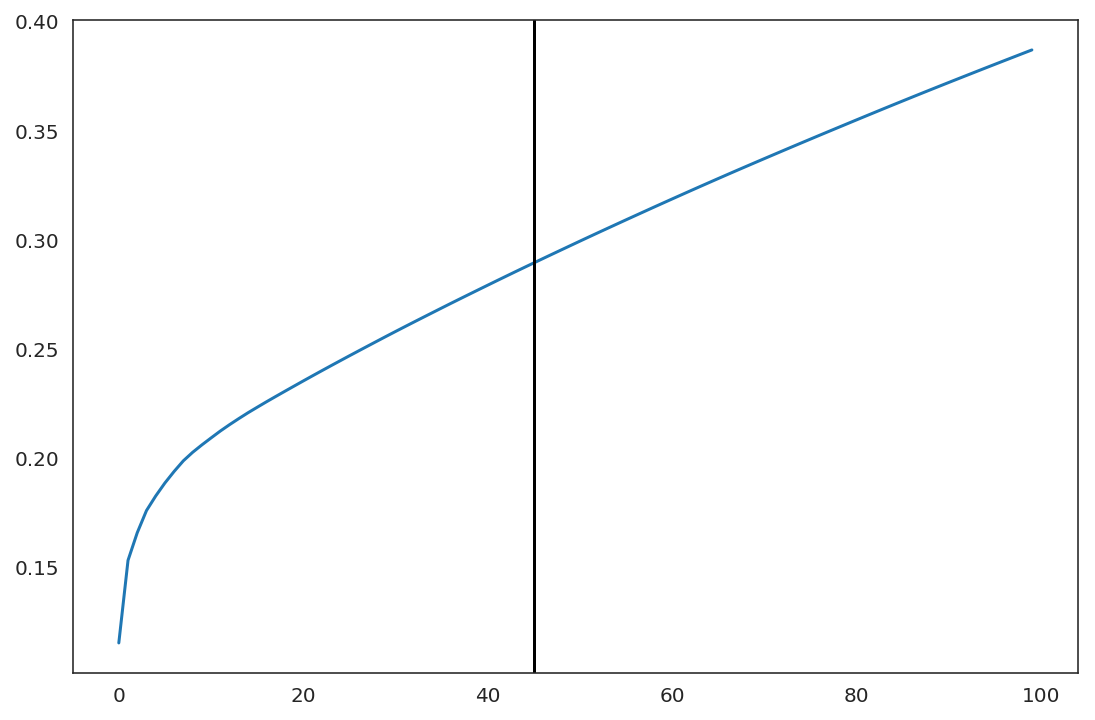

In [85]:
# perform PCA
oracle.perform_PCA()

# select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. Knn imputation

In [21]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :2671


In [22]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :66


In [23]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.

Celloracle has some custom-class; Links, Oracle, TFinfo, etc.,
You can save such object using "to_hdf5". The file will be saved as a hdf5 file.

To load saved file, pleasae use "load_hdf5" function.


In [24]:
# save oracle object.
oracle.to_hdf5("Paul_15_data.celloracle.oracle")

In [68]:
# load file.
# oracle = co.load_hdf5("Paul_15_data.celloracle.oracle")

# 4. GRN calculation
Next step is constructing a cluster-specific GRN for all clusters.

GRN can be calculated at any arbitrary unit. 

With "get_links" function, you can calculate cluster-specific GRNs at any unit, and the function returns GRNs as Links object.
Links object stores inferred GRNs and its metadata. You can do network analysis with Links object.



In the example below, we will make GRNs based on "louvain_annot" clustering unit.

You can use any clustering unit for GRN calculation as long as clustering information is saved in anndata.

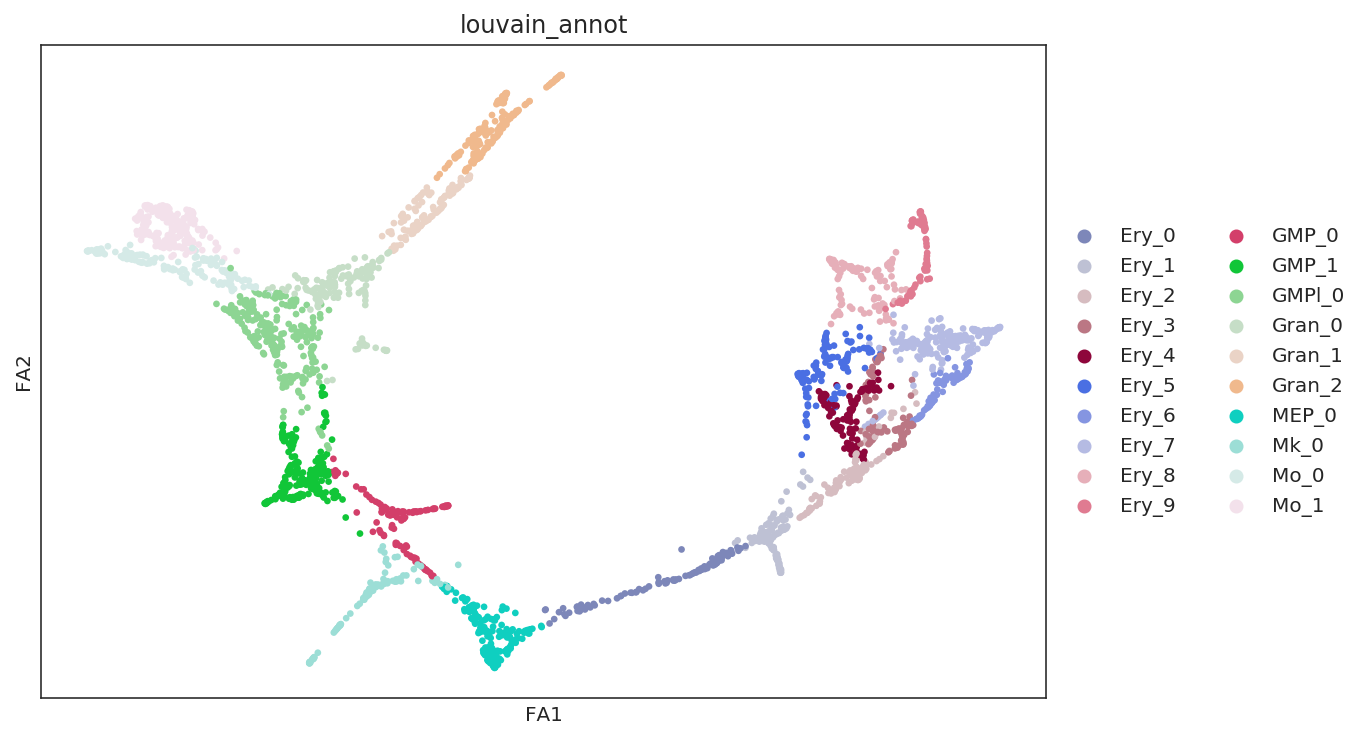

In [86]:
# check data
sc.pl.draw_graph(oracle.adata, color="louvain_annot")

In [28]:
# calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take long time.
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=2, test_mode=False)


inferring GRN for Ery_0...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_1...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_2...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_3...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_4...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_5...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_6...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_7...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_8...
method: bagging_ridge
alpha: 10



inferring GRN for Ery_9...
method: bagging_ridge
alpha: 10



inferring GRN for GMP_0...
method: bagging_ridge
alpha: 10



inferring GRN for GMP_1...
method: bagging_ridge
alpha: 10



inferring GRN for GMPl_0...
method: bagging_ridge
alpha: 10



inferring GRN for Gran_0...
method: bagging_ridge
alpha: 10



inferring GRN for Gran_1...
method: bagging_ridge
alpha: 10



inferring GRN for Gran_2...
method: bagging_ridge
alpha: 10



inferring GRN for MEP_0...
method: bagging_ridge
alpha: 10



inferring GRN for Mk_0...
method: bagging_ridge
alpha: 10



inferring GRN for Mo_0...
method: bagging_ridge
alpha: 10



inferring GRN for Mo_1...
method: bagging_ridge
alpha: 10


Links object have some metadata.


In [33]:
links.palette

palette
Ery_0   #7D87B9
Ery_1   #BEC1D4
Ery_2   #D6BCC0
Ery_3   #BB7784
Ery_4   #8E063B
Ery_5   #4A6FE3
Ery_6   #8595E1
Ery_7   #B5BBE3
Ery_8   #E6AFB9
Ery_9   #E07B91
GMP_0   #D33F6A
GMP_1   #11C638
GMPl_0  #8DD593
Gran_0  #C6DEC7
Gran_1  #EAD3C6
Gran_2  #F0B98D
MEP_0   #0FCFC0
Mk_0    #9CDED6
Mo_0    #D5EAE7
Mo_1    #F3E1EB

For the visualization below, we change the order of clusters.

In [35]:

# For the visualization below, we define and save order of clusters.
order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5',
         'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','GMP_0', 'GMP_1',
         'GMPl_0', 'Mo_0', 'Mo_1', 'Gran_0', 'Gran_1', 'Gran_2']
links_louvain.palette = links_louvain.palette.loc[order]
links_louvain.palette

palette
MEP_0   #0FCFC0
Mk_0    #9CDED6
Ery_0   #7D87B9
Ery_1   #BEC1D4
Ery_2   #D6BCC0
Ery_3   #BB7784
Ery_4   #8E063B
Ery_5   #4A6FE3
Ery_6   #8595E1
Ery_7   #B5BBE3
Ery_8   #E6AFB9
Ery_9   #E07B91
GMP_0   #D33F6A
GMP_1   #11C638
GMPl_0  #8DD593
Mo_0    #D5EAE7
Mo_1    #F3E1EB
Gran_0  #C6DEC7
Gran_1  #EAD3C6
Gran_2  #F0B98D

# 5. Network preprocessing

## 5.1. Filter network edges 
Celloracle leverages bagging ridge or Bayesian ridge regression for network inference. 
These methods provide a network edge strength as a distribution rather than point value. 
We can use the distribution of the network edge strength to know the certainness of the connection.

We will do filtering of network edge before starting network analysis.

 (1) Remove uncertain network edge based on the p-value.
 
 (2) Remove weak network edge. In this tutorial, we pick up top 2000 edges in terms of network strength.


The raw network data is stored as an attribute, "links_dict," while filtered network data will be stored in "filtered_links."
So the raw network data will not be erased after the filtering. You can come back to the filtering process and do the filtering again if you do not like filtering results.

In [32]:
links.filter_links(p=0.001, weight="coef_abs", thread_number=2000)

## 5.2. Degree distribution 
Network degree, which means the number of edges for each gene, is one of the important metrics to know the network analysis.
The degree distribution may change depending on the filtering threshold.

Ery_0


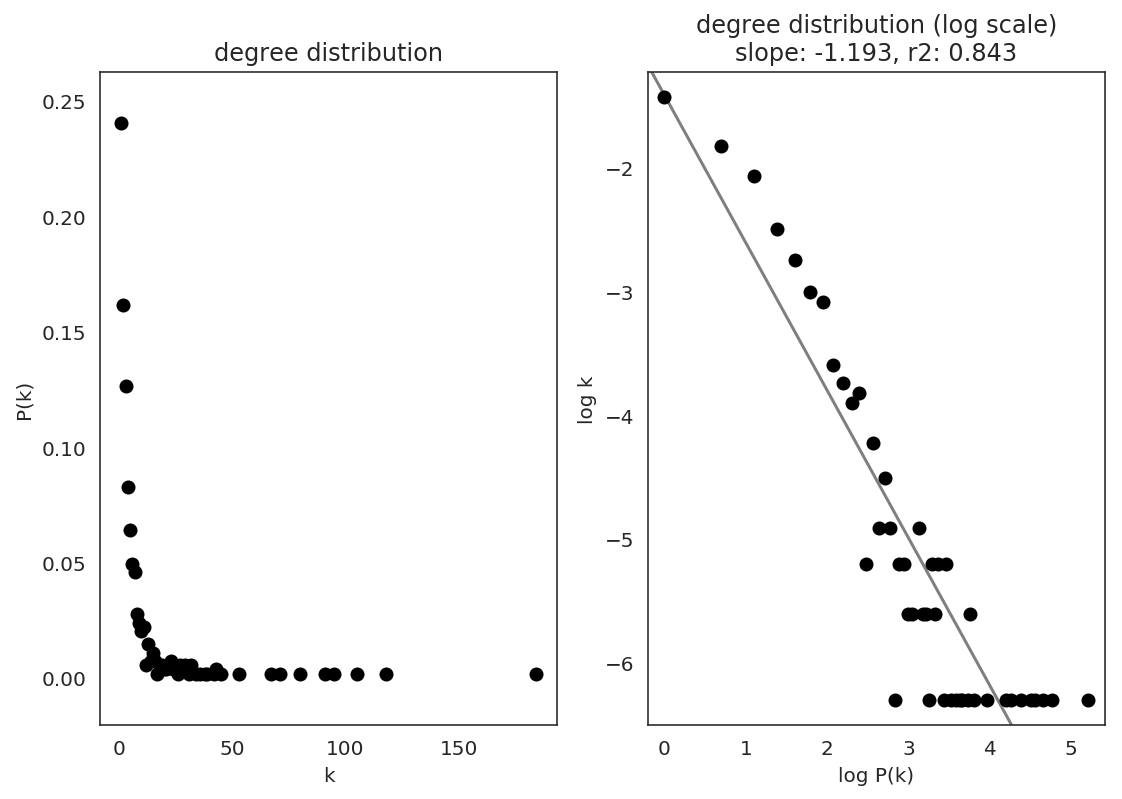

Ery_1


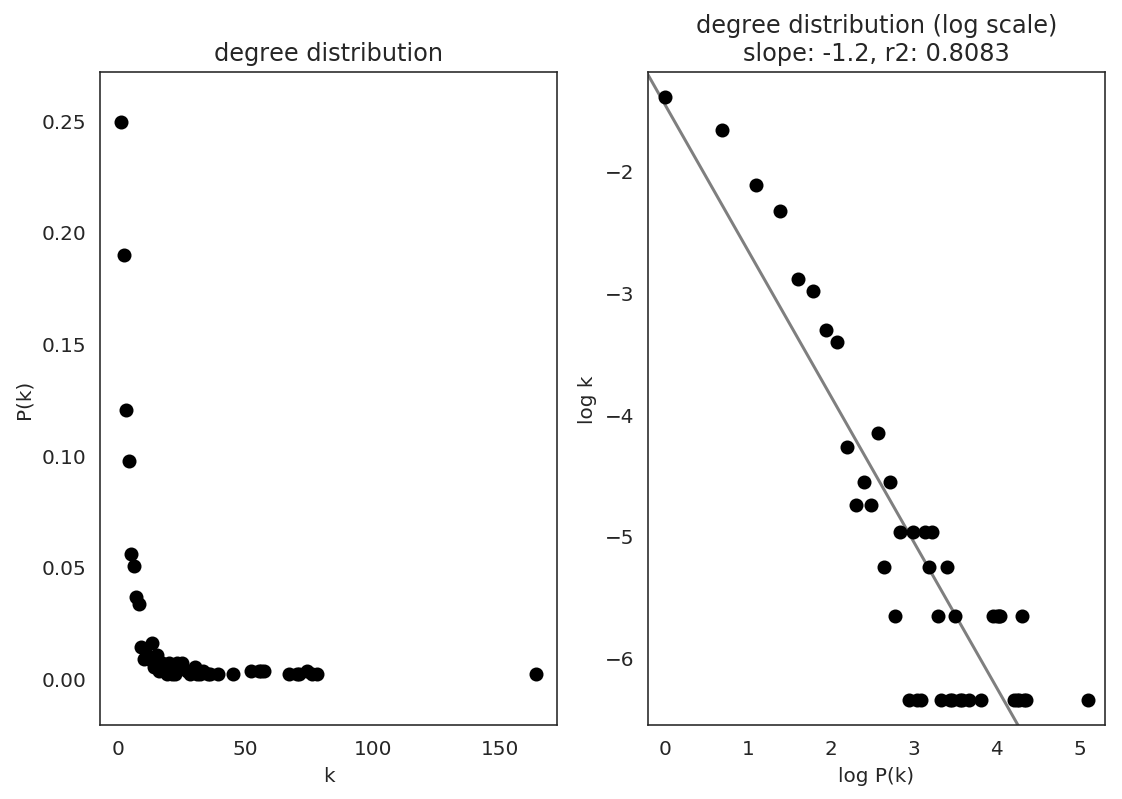

Ery_2


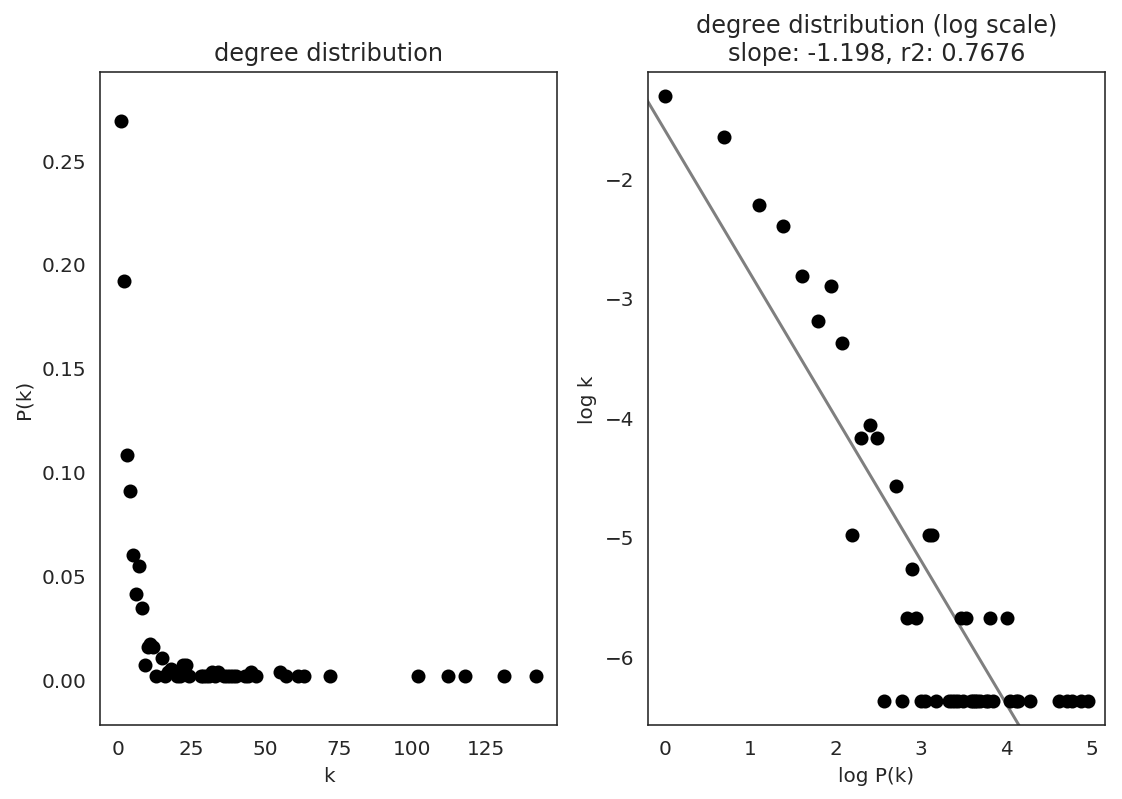

Ery_3


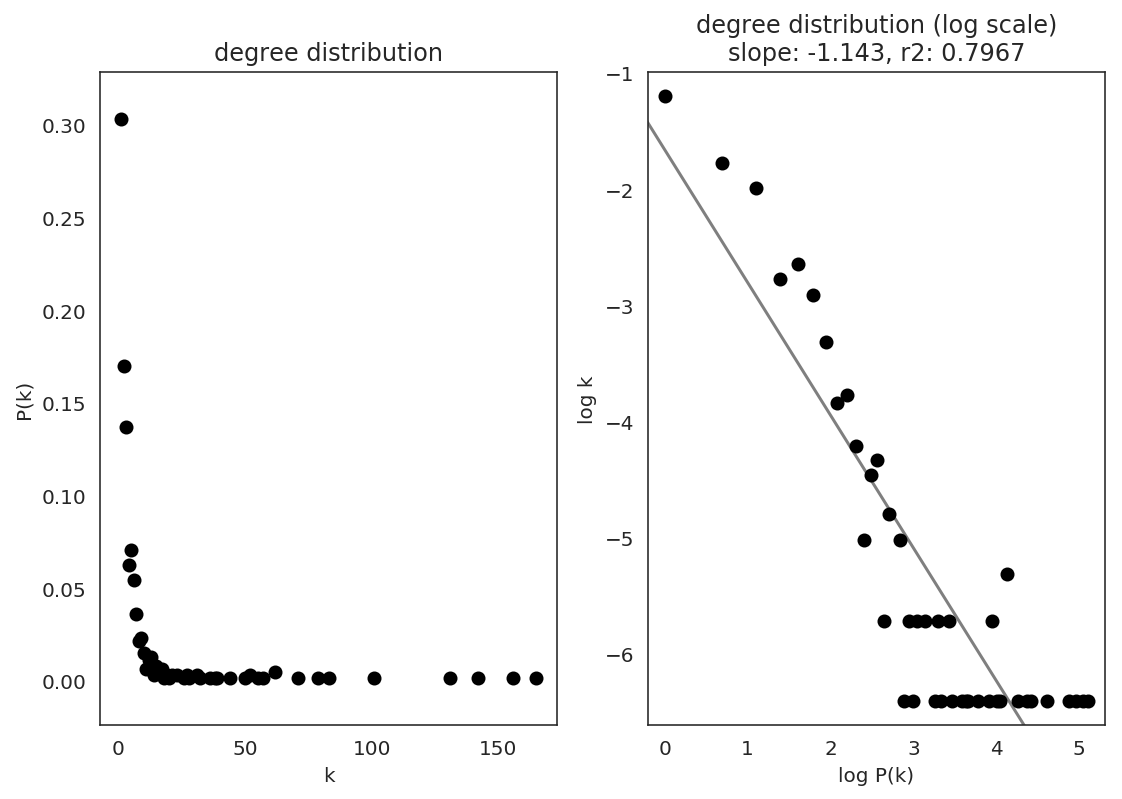

Ery_4


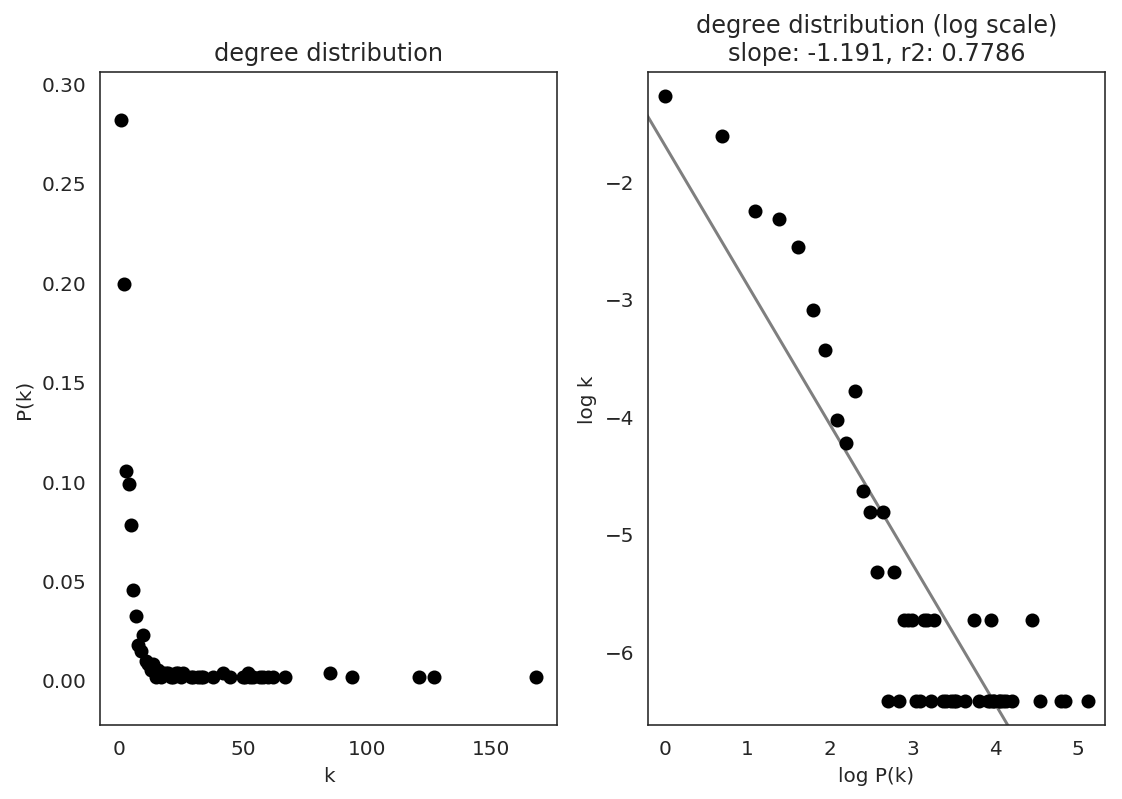

Ery_5


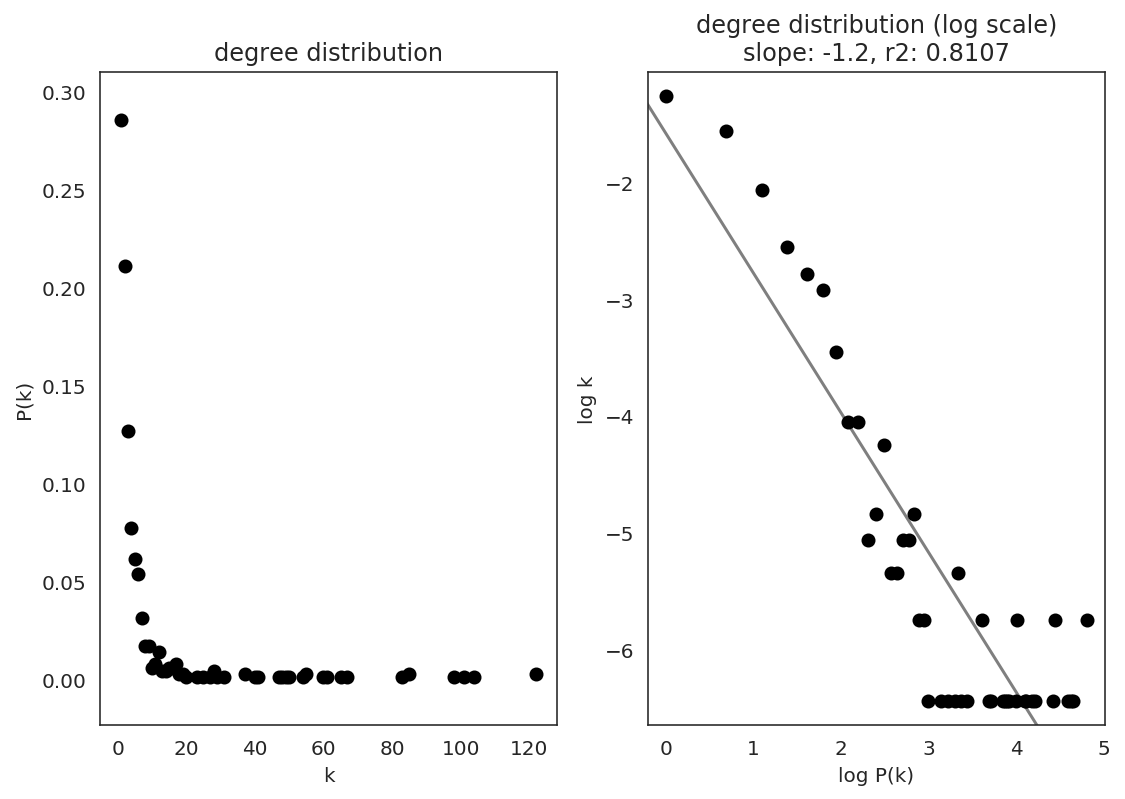

Ery_6


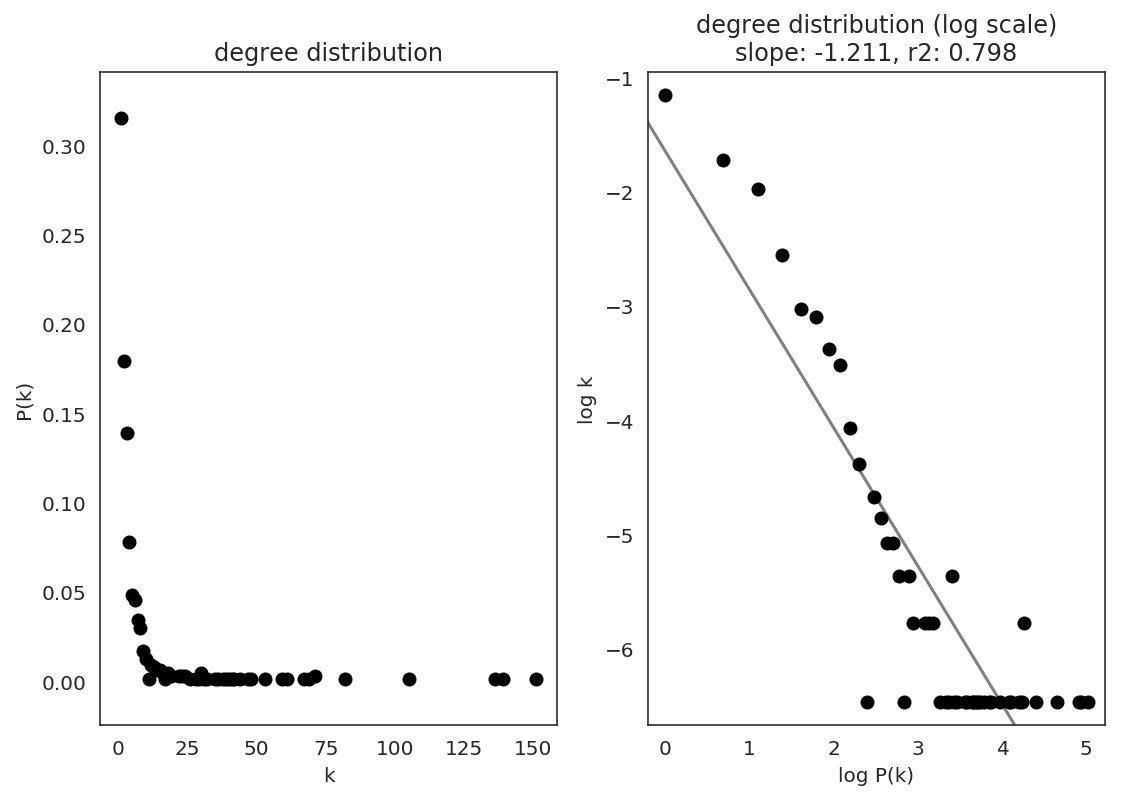

Ery_7


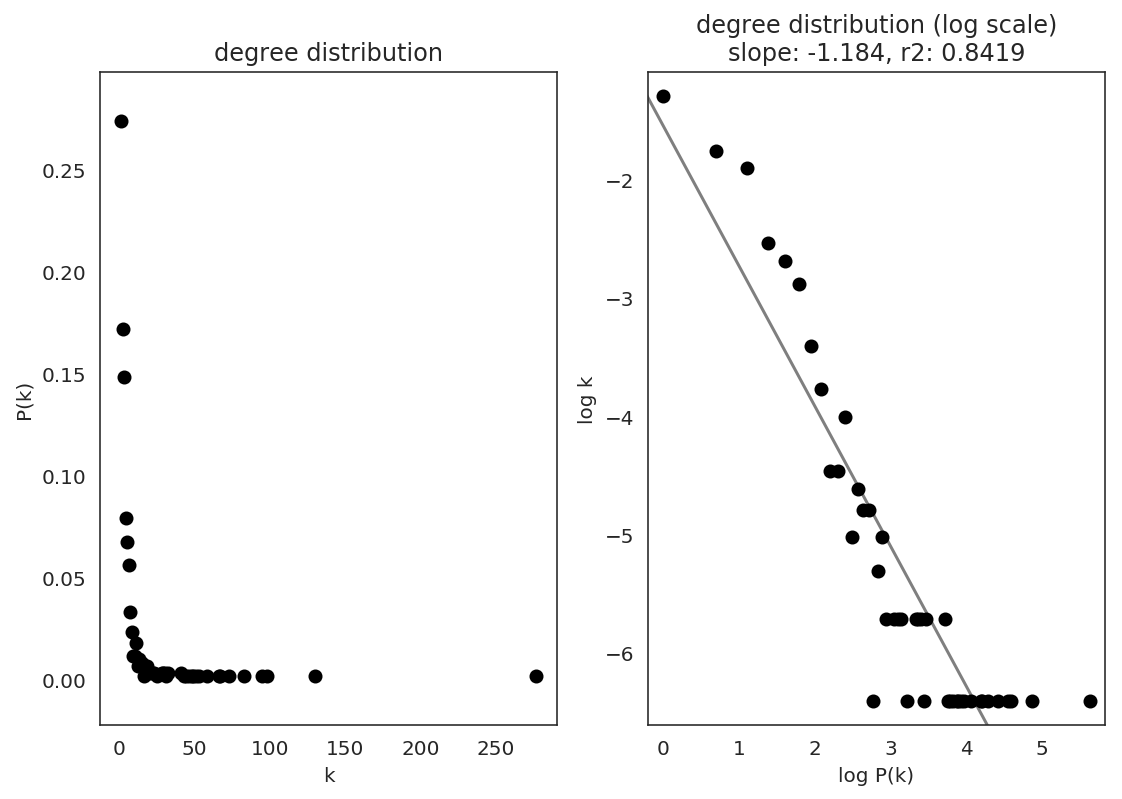

Ery_8


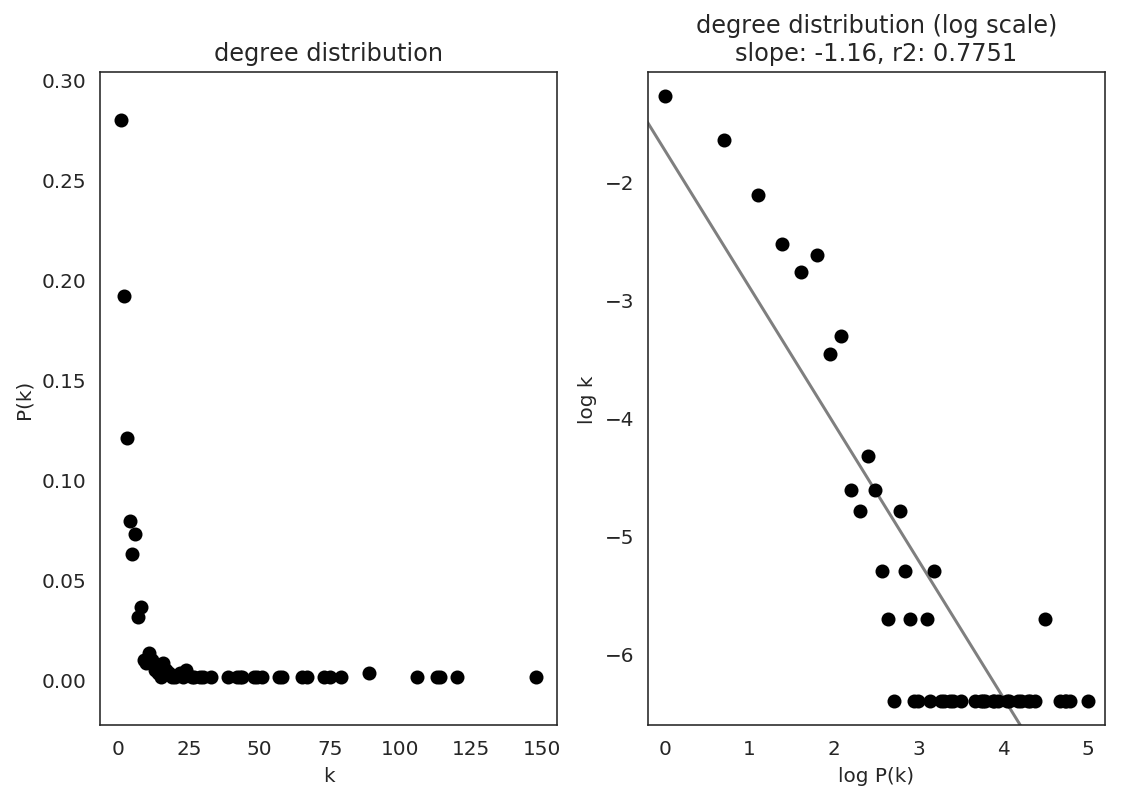

Ery_9


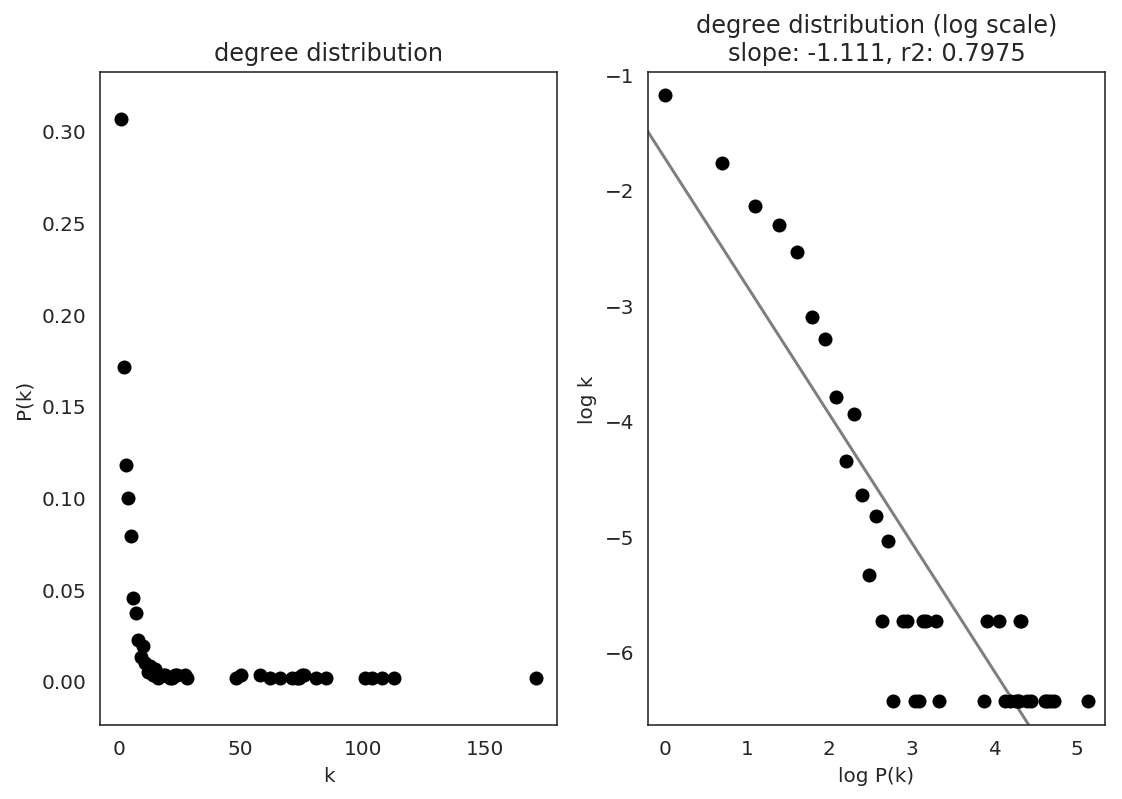

GMP_0


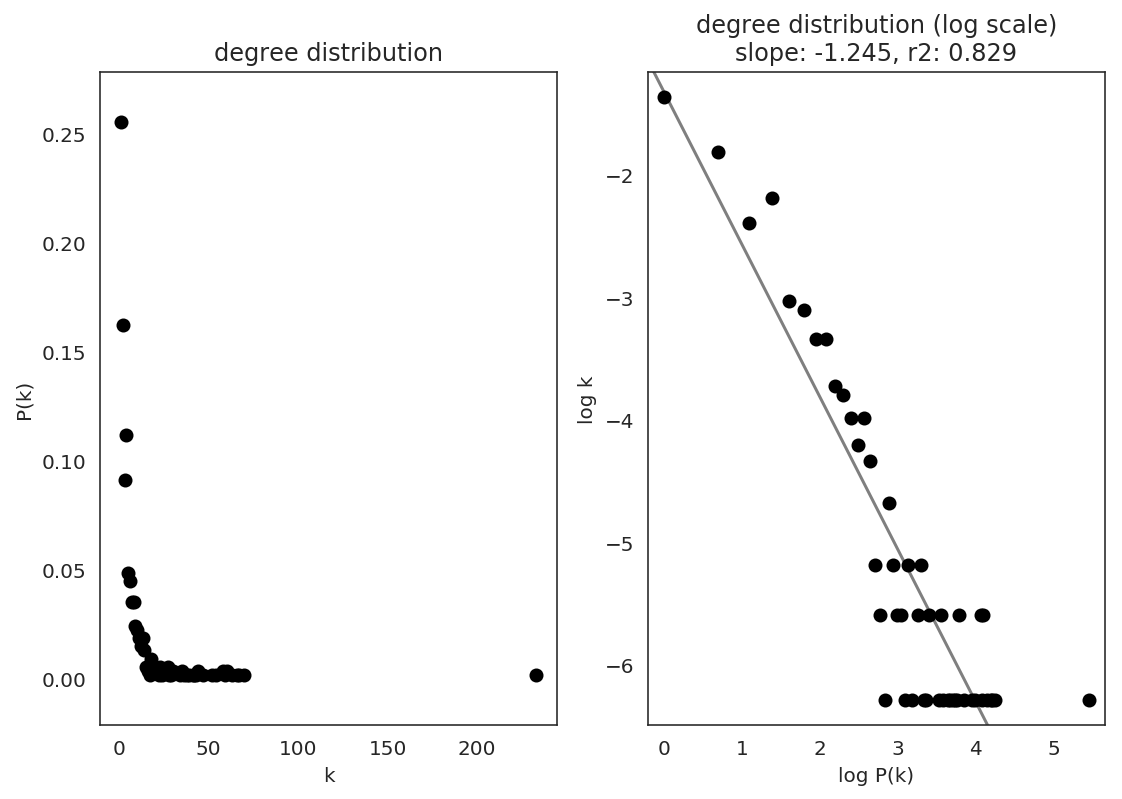

GMP_1


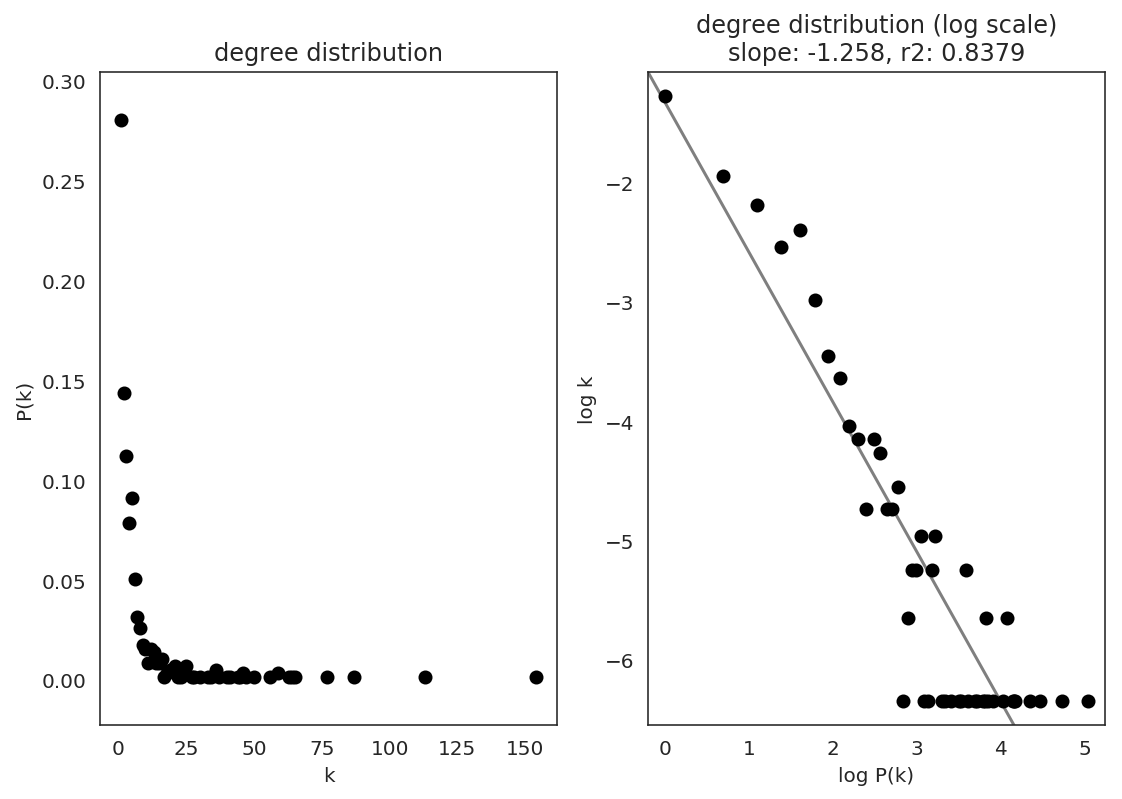

GMPl_0


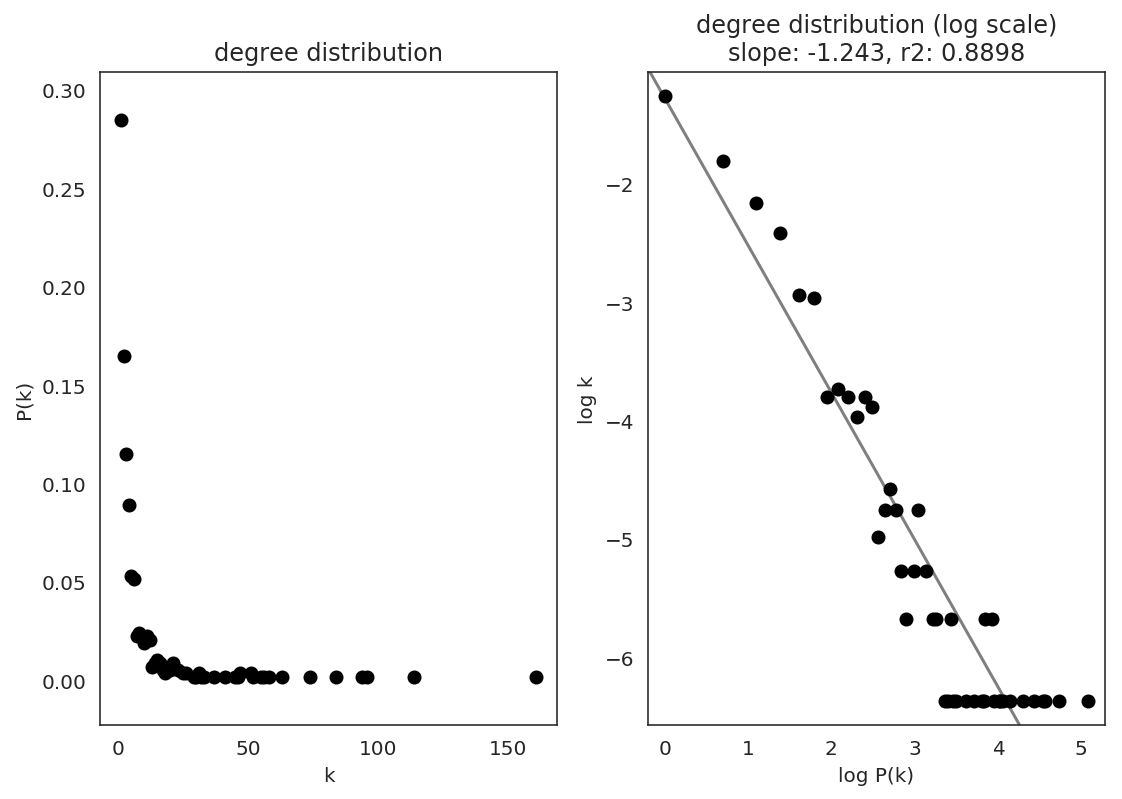

Gran_0


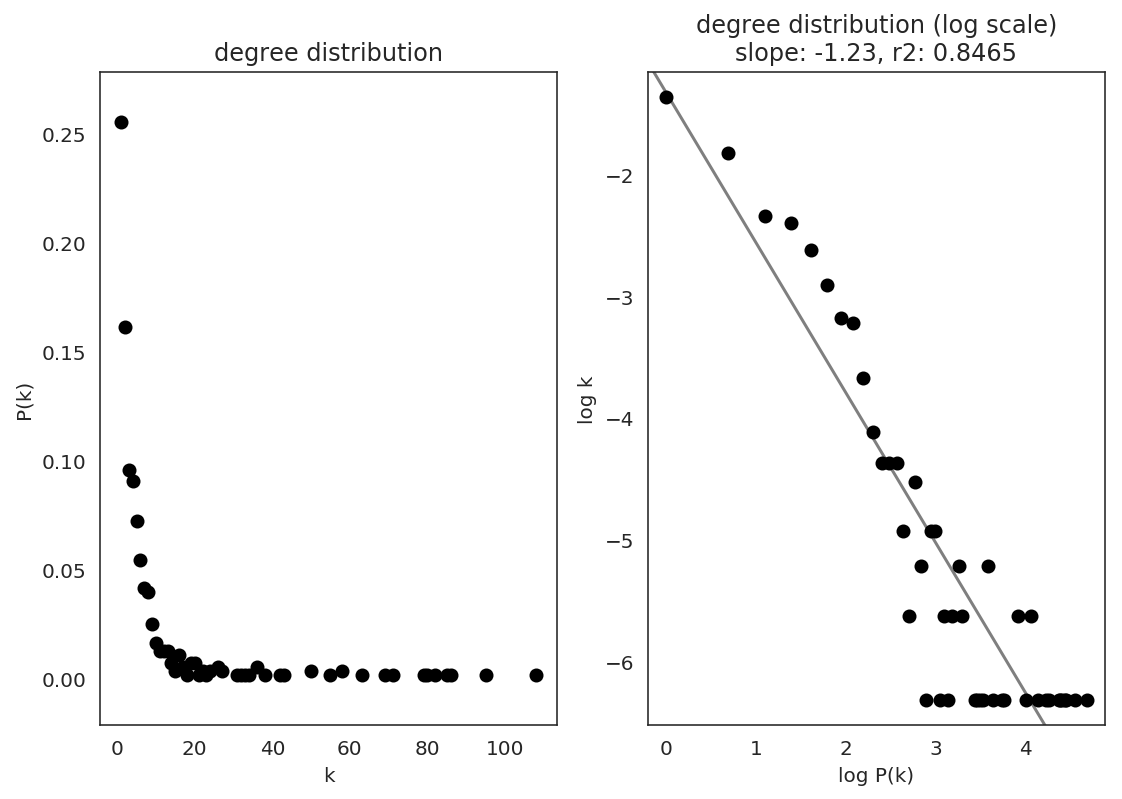

Gran_1


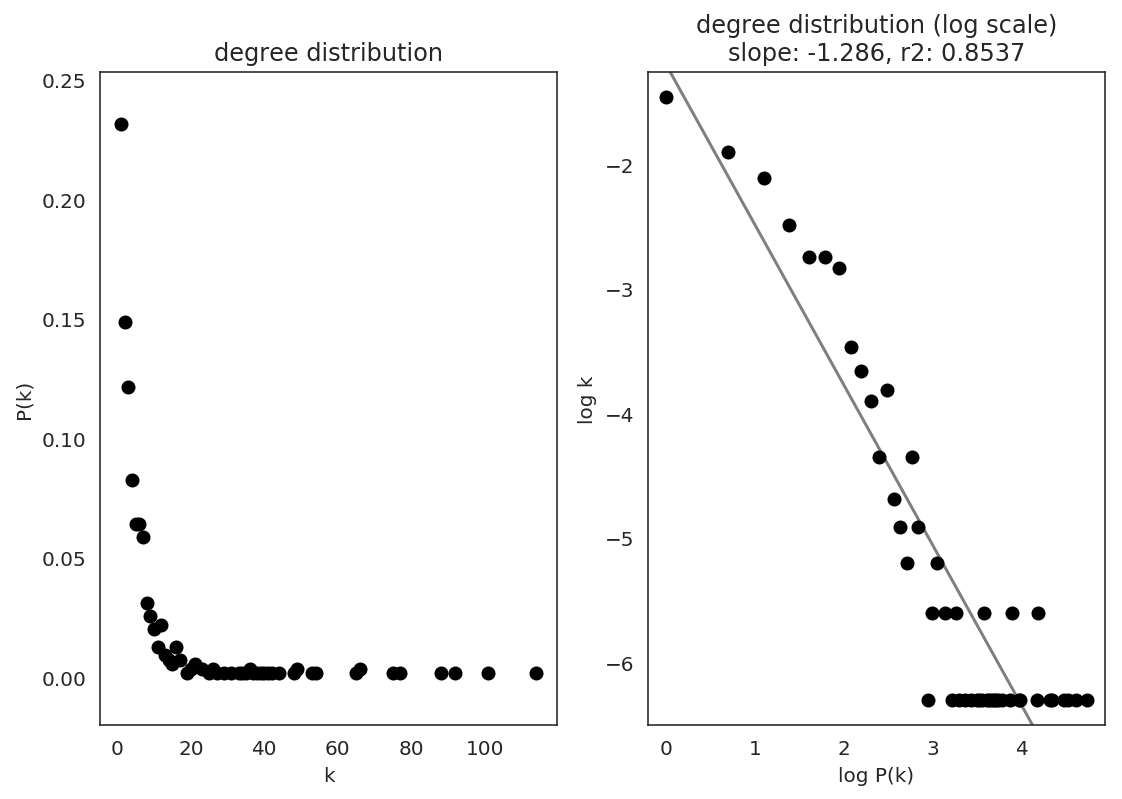

Gran_2


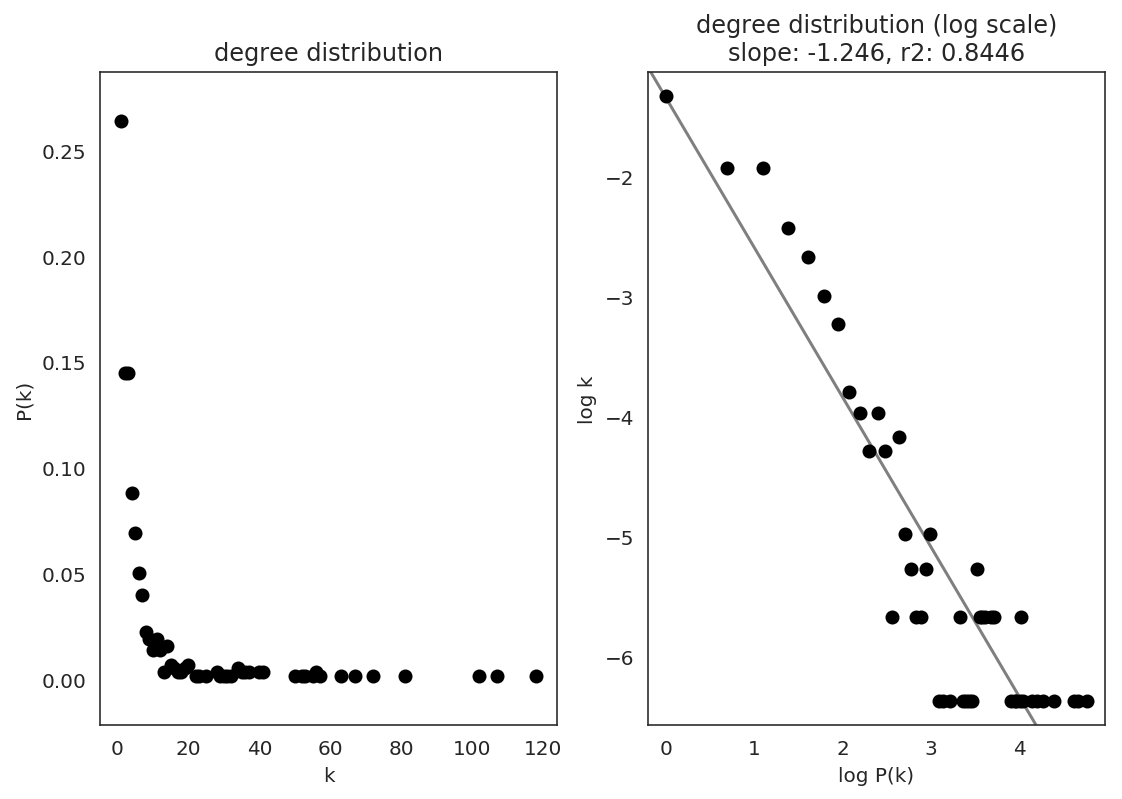

MEP_0


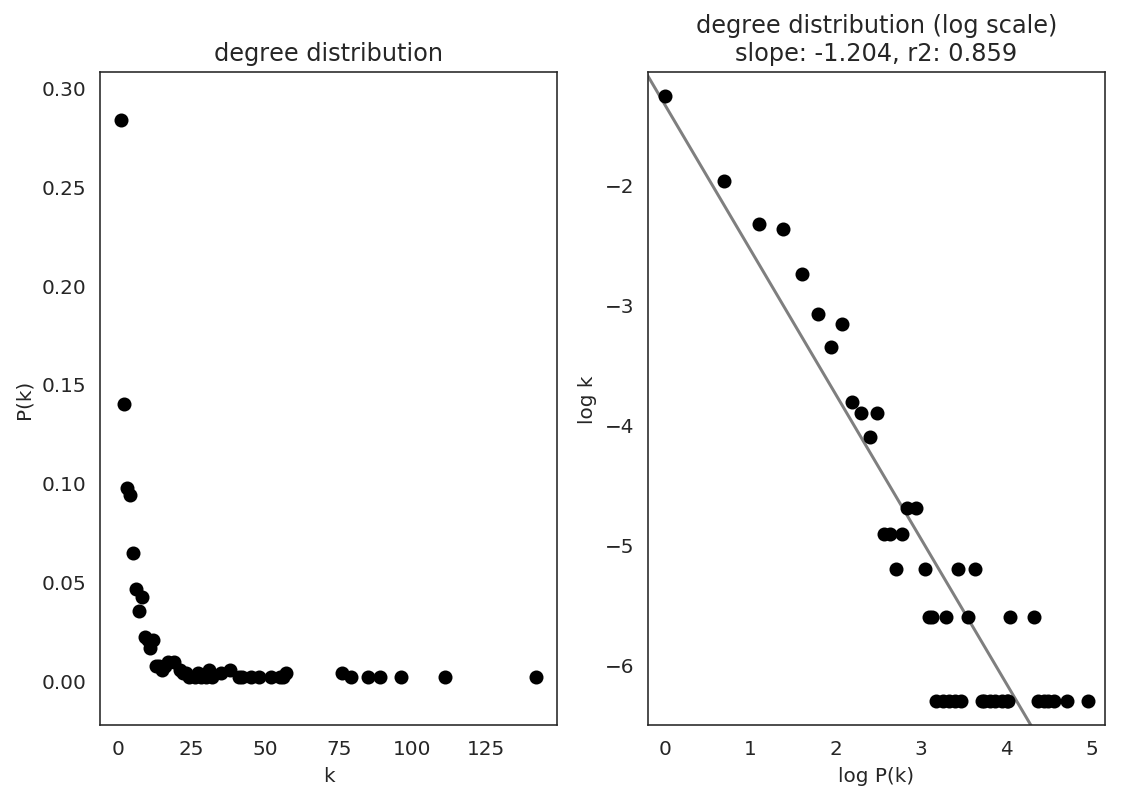

Mk_0


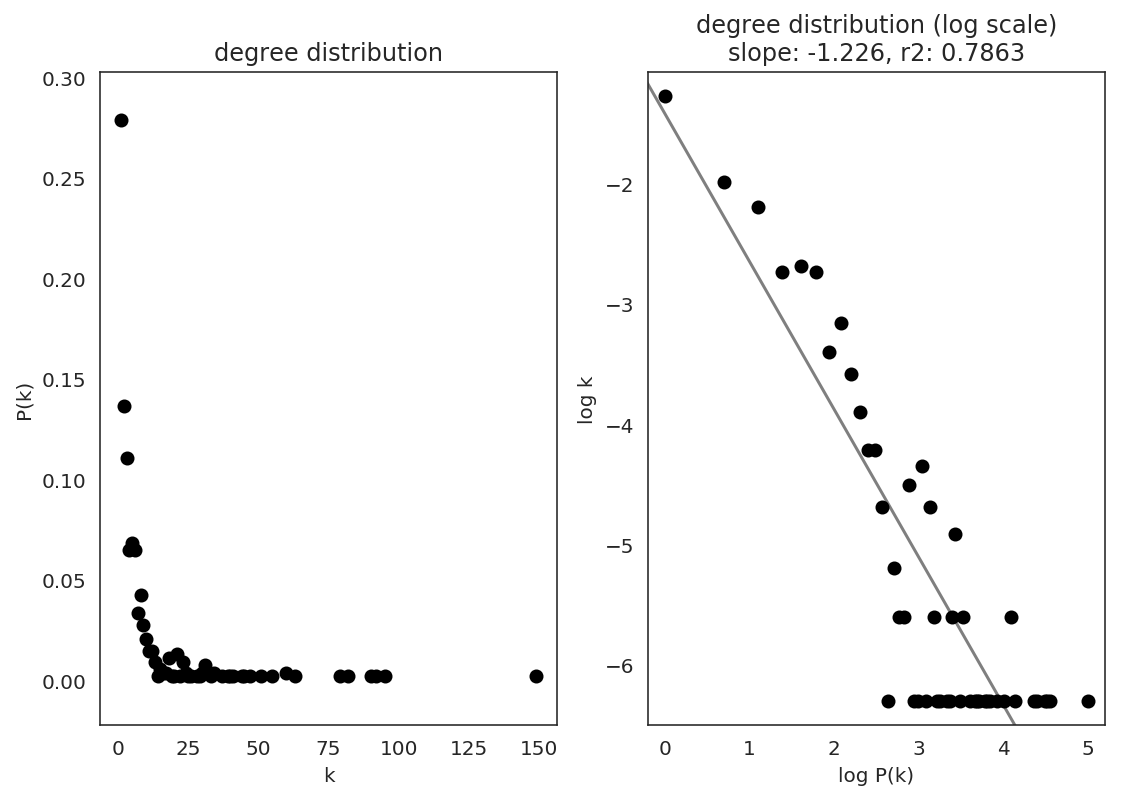

Mo_0


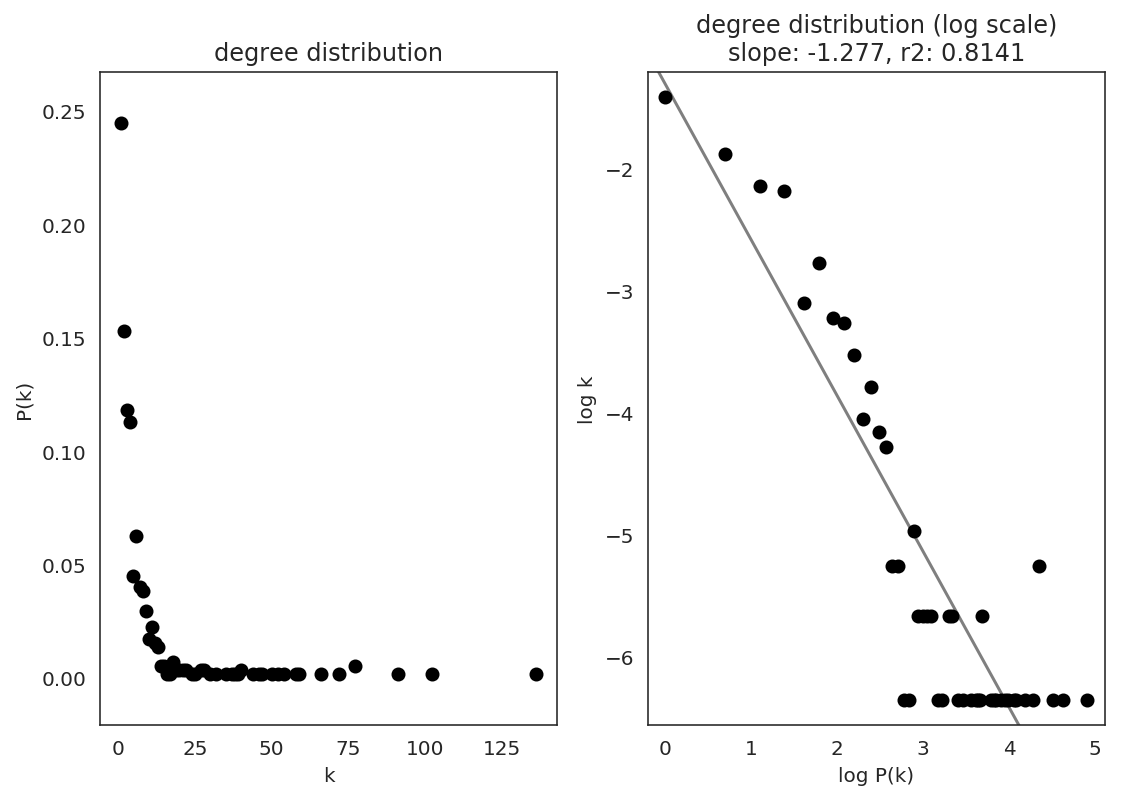

Mo_1


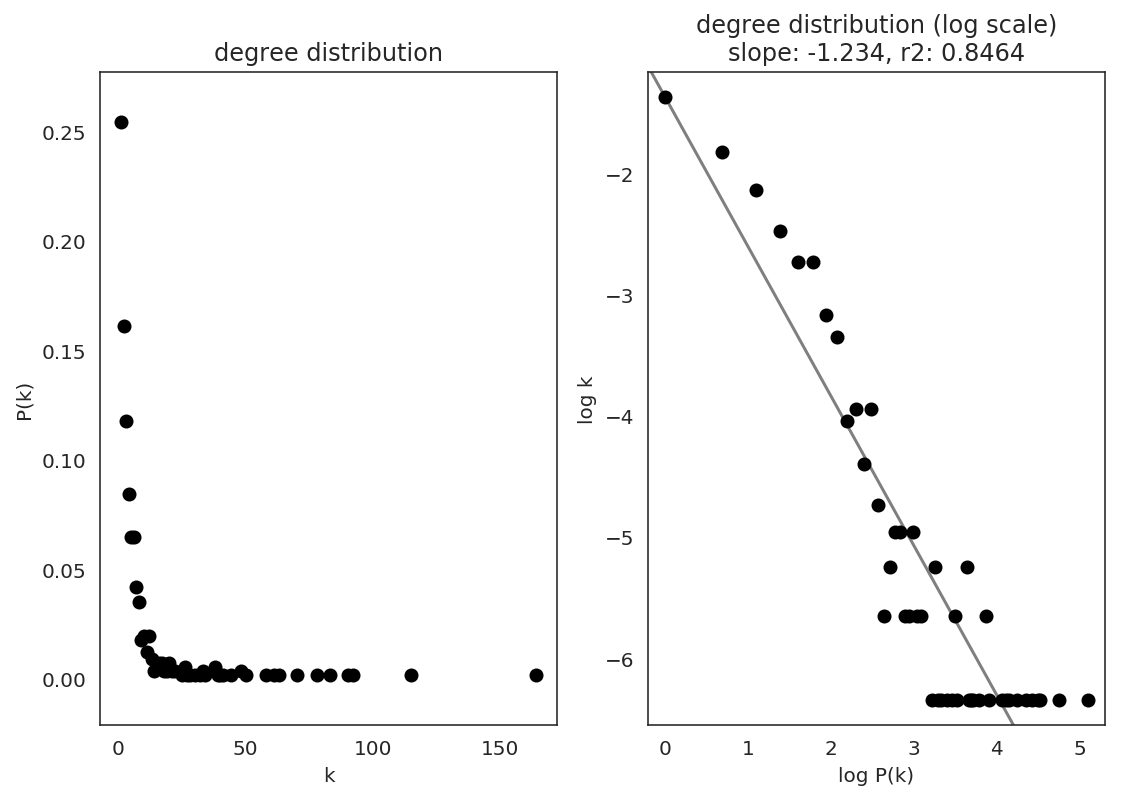

In [87]:
links.plot_degree_distributions(plot_model=True, save=f"{save_folder}/degree_distribution/")

## 5.3. Calculate netowrk score

Next, we calculate several network score using some R libraries.
Please make sure that R libraries are installed in your PC before running the command below.


In [39]:
# calculate network scores. It takes several minuts.
links.get_score()

processing... batch 1/5
Ery_0: finished.
Ery_1: finished.
Ery_2: finished.
Ery_3: finished.
processing... batch 2/5
Ery_4: finished.
Ery_5: finished.
Ery_6: finished.
Ery_7: finished.
processing... batch 3/5
Ery_8: finished.
Ery_9: finished.
GMP_0: finished.
GMP_1: finished.
processing... batch 4/5
GMPl_0: finished.
Gran_0: finished.
Gran_1: finished.
Gran_2: finished.
processing... batch 5/5
MEP_0: finished.
Mk_0: finished.
Mo_0: finished.
Mo_1: finished.
the scores are saved in ./louvain_annot/


The score is stored as a attribute "merged_score", and score will also be saved in a folder.

In [57]:
links.merged_score.head()

degree_all  degree_in  degree_out  clustering_coefficient  \
Stat3          91          0          91                0.019780   
Mycn           28          0          28                0.002646   
Zbtb1          27          0          27                0.005698   
E2f4          186          3         183                0.009474   
Ybx1           71          9          62                0.027364   

       clustering_coefficient_weighted  degree_centrality_all  \
Stat3                         0.020122               0.167279   
Mycn                          0.001828               0.051471   
Zbtb1                         0.008576               0.049632   
E2f4                          0.011623               0.341912   
Ybx1                          0.027485               0.130515   

       degree_centrality_in  degree_centrality_out  betweenness_centrality  \
Stat3              0.000000               0.167279                       0   
Mycn               0.000000               0.051471                       0   
Zbtb1              0.000000               0.049632                       0   
E2f4               0.005515               0.336397                    2788   
Ybx1               0.016544               0.113971                    1153   

       closeness_centrality  ...  assortative_coefficient  \
Stat3              0.000013  ...                -0.172207   
Mycn               0.000004  ...                -0.172207   
Zbtb1              0.000011  ...                -0.172207   
E2f4               0.000010  ...                -0.172207   
Ybx1               0.000004  ...                -0.172207   

       average_path_length  community_edge_betweenness  community_random_walk  \
Stat3             2.475244                           1                      1   
Mycn              2.475244                           2                      1   
Zbtb1             2.475244                           3                      1   
E2f4              2.475244                           4                      1   
Ybx1              2.475244                           5                     11   

       community_eigenvector  module  connectivity  participation  \
Stat3                      1       0      4.052023       0.632291   
Mycn                       5       2      2.347146       0.625000   
Zbtb1                      5       1      2.275431       0.666667   
E2f4                       3       0      8.496354       0.637760   
Ybx1                       4       3      5.433857       0.564967   

                role  cluster  
Stat3  Connector Hub    Ery_0  
Mycn       Connector    Ery_0  
Zbtb1      Connector    Ery_0  
E2f4   Connector Hub    Ery_0  
Ybx1   Connector Hub    Ery_0  

[5 rows x 22 columns]

## 5.4. Save

Save processed GRN. The Links file will also be used in the next notebook; "in silico simulation with GRNs". 

In [42]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

# You can load files with the following command.
#links = co.load_hdf5(file_path="links.celloracle.links")


If you are not interested in the network score analysis and just want to do simulation, you can skip the analysis below and go to the next notebook.

# 6. Network analysis; Network score for each gene
Links class has many functions to visualize network score.
See the documentation for the details of the functions.

## 6.1. Network score in each cluster


In [44]:
# check cluster
links.cluster

['Ery_0',
 'Ery_1',
 'Ery_2',
 'Ery_3',
 'Ery_4',
 'Ery_5',
 'Ery_6',
 'Ery_7',
 'Ery_8',
 'Ery_9',
 'GMP_0',
 'GMP_1',
 'GMPl_0',
 'Gran_0',
 'Gran_1',
 'Gran_2',
 'MEP_0',
 'Mk_0',
 'Mo_0',
 'Mo_1']

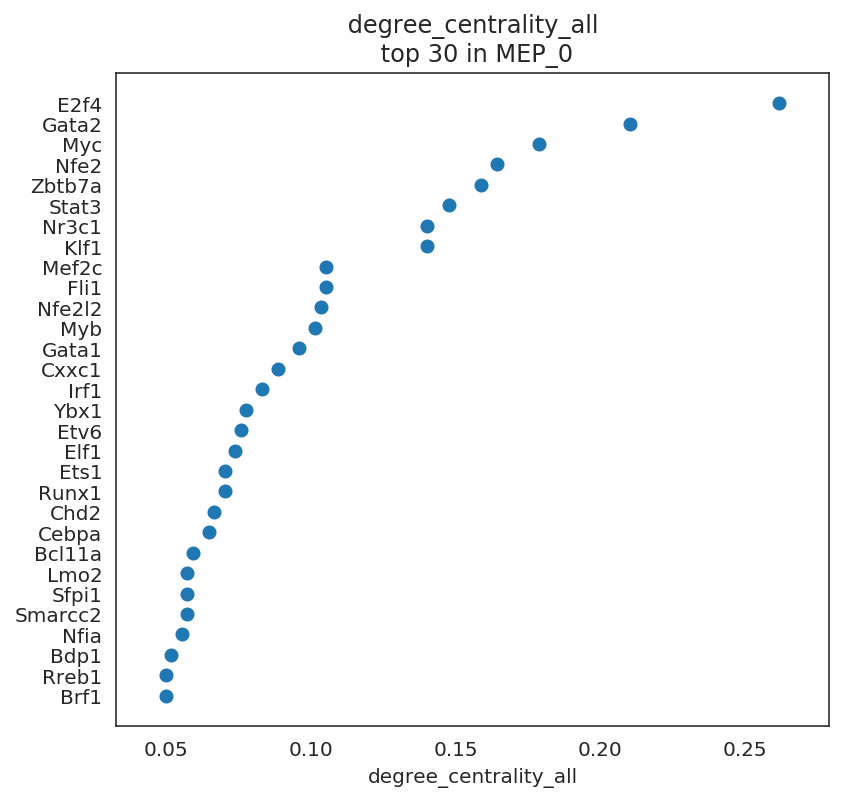

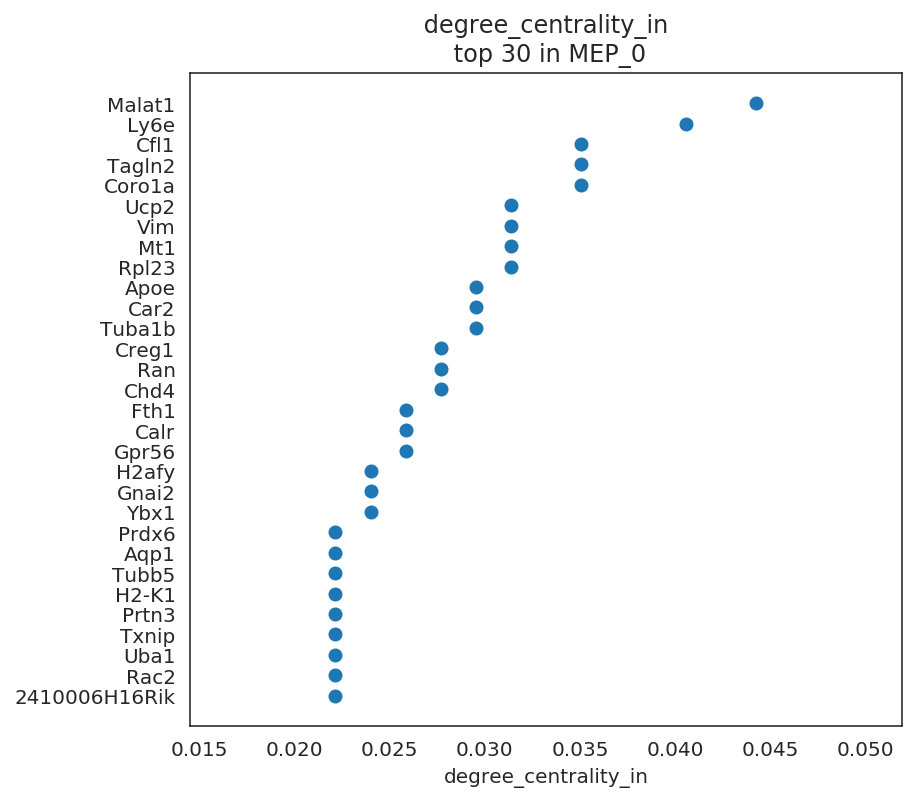

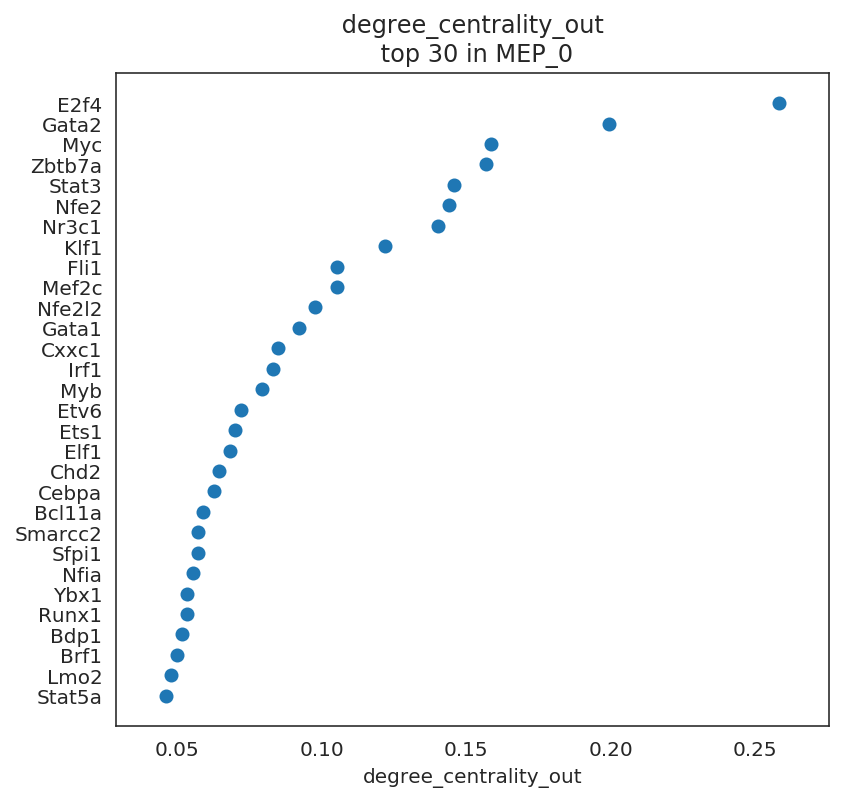

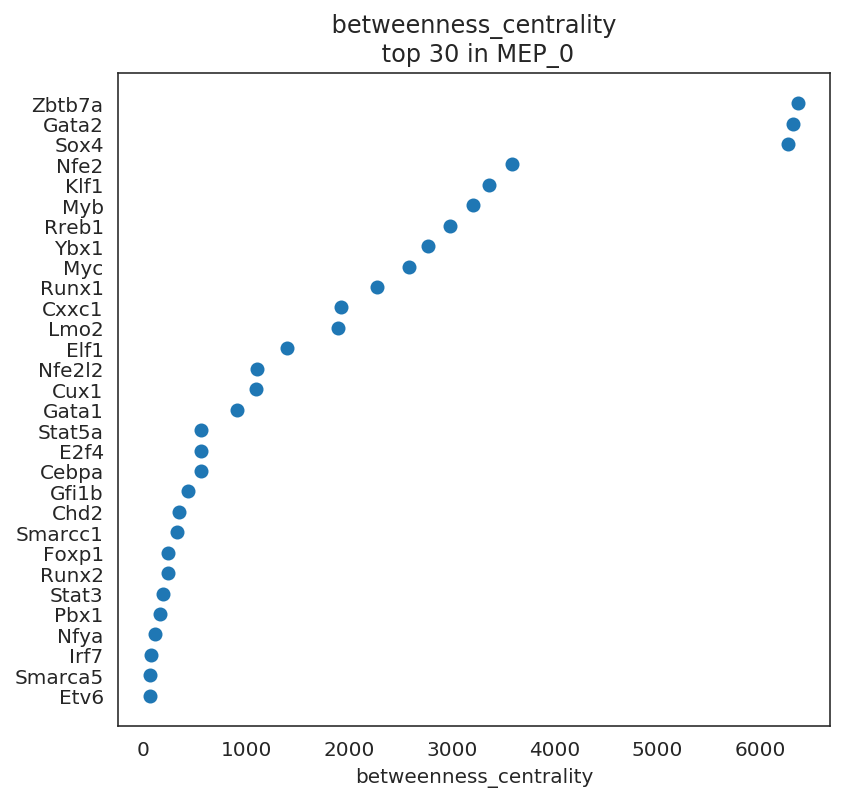

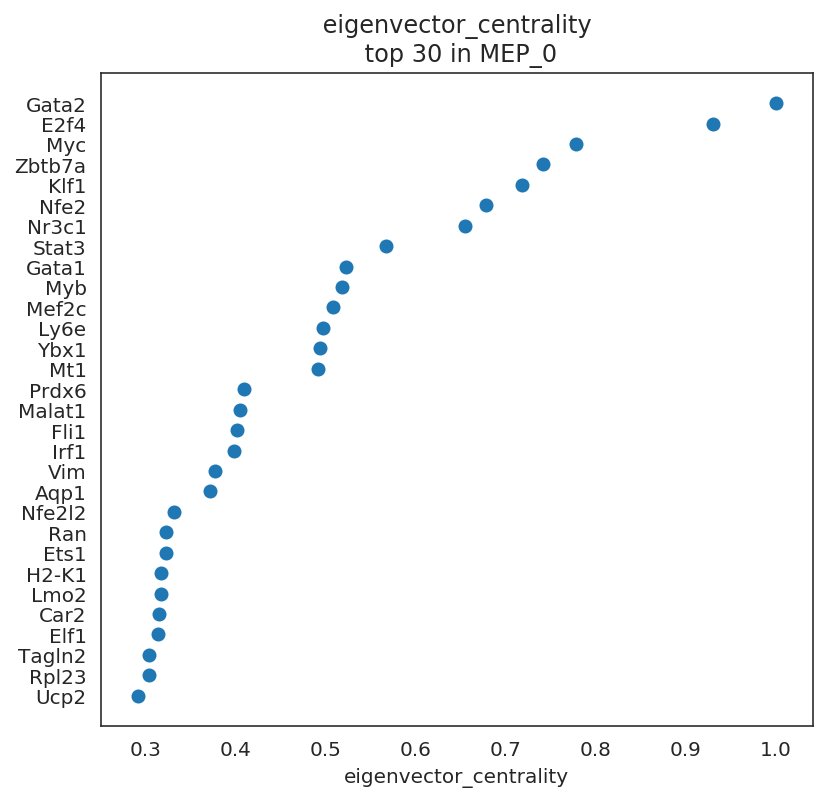

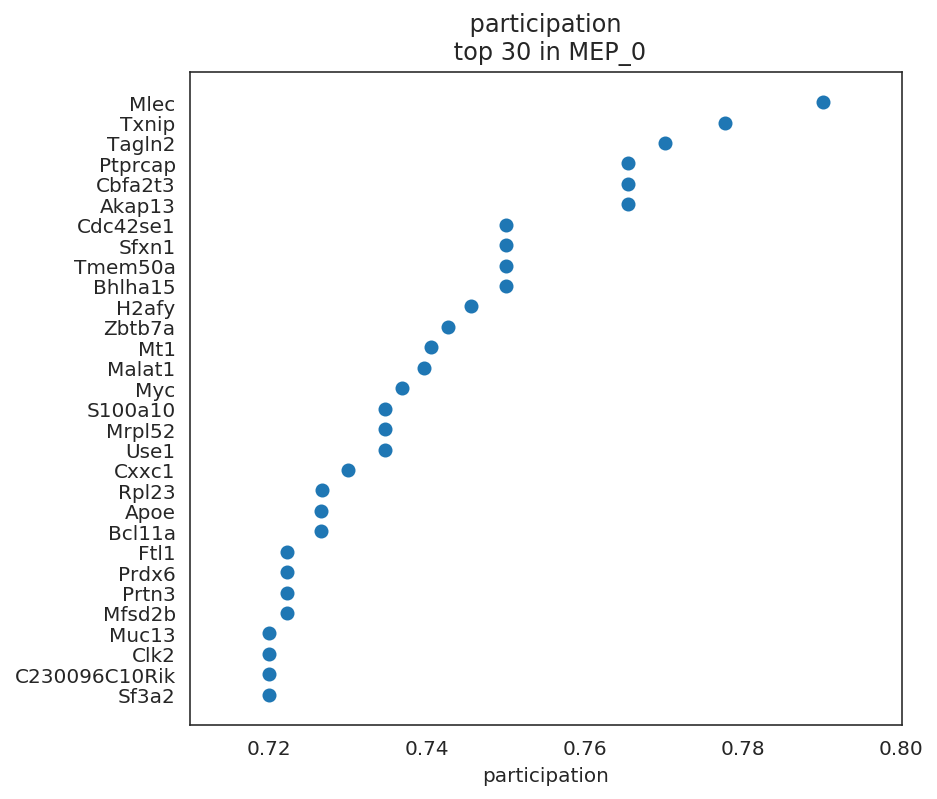

In [88]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="MEP_0", n_gene=30, save=f"{save_folder}/ranked_score")

## 6.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze the difference of GRN structure.

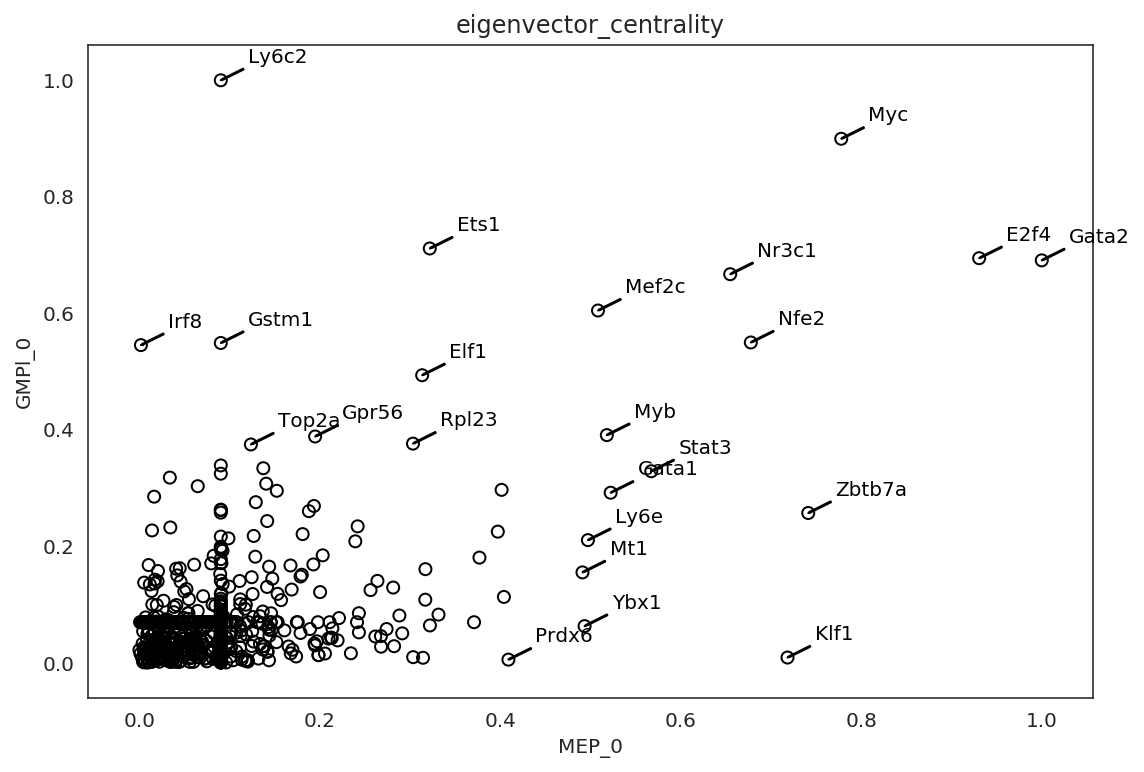

In [89]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

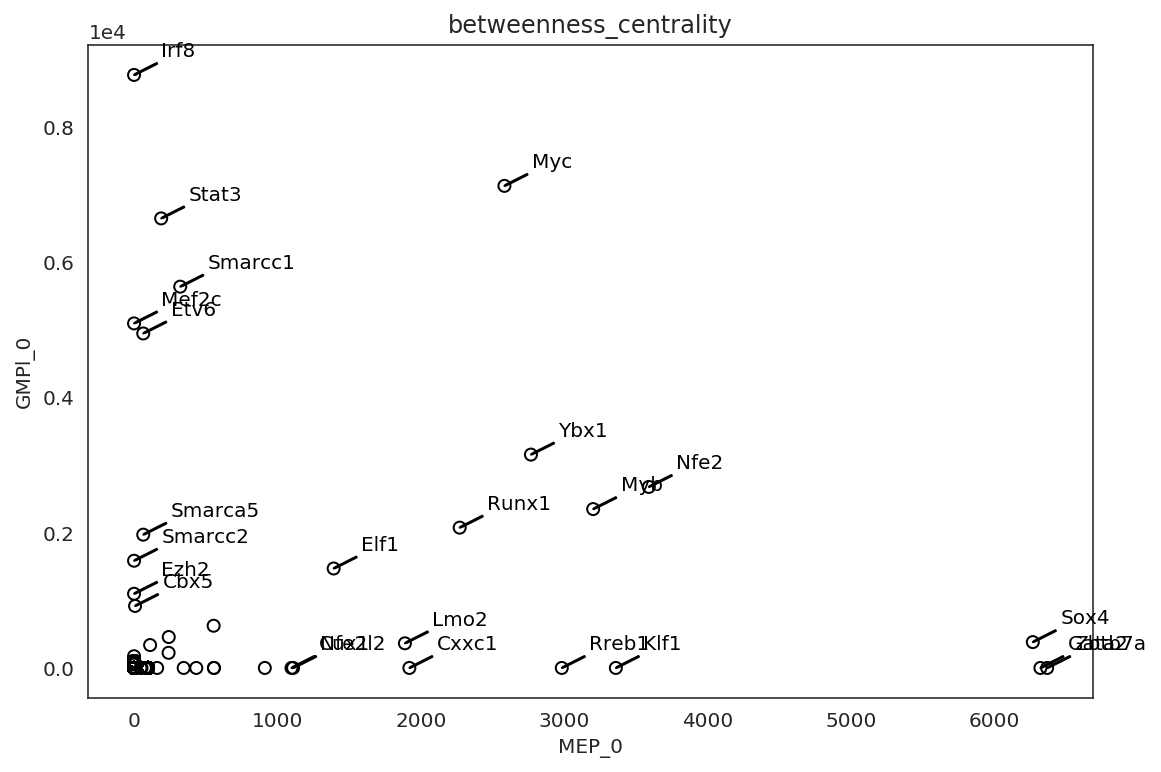

In [90]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

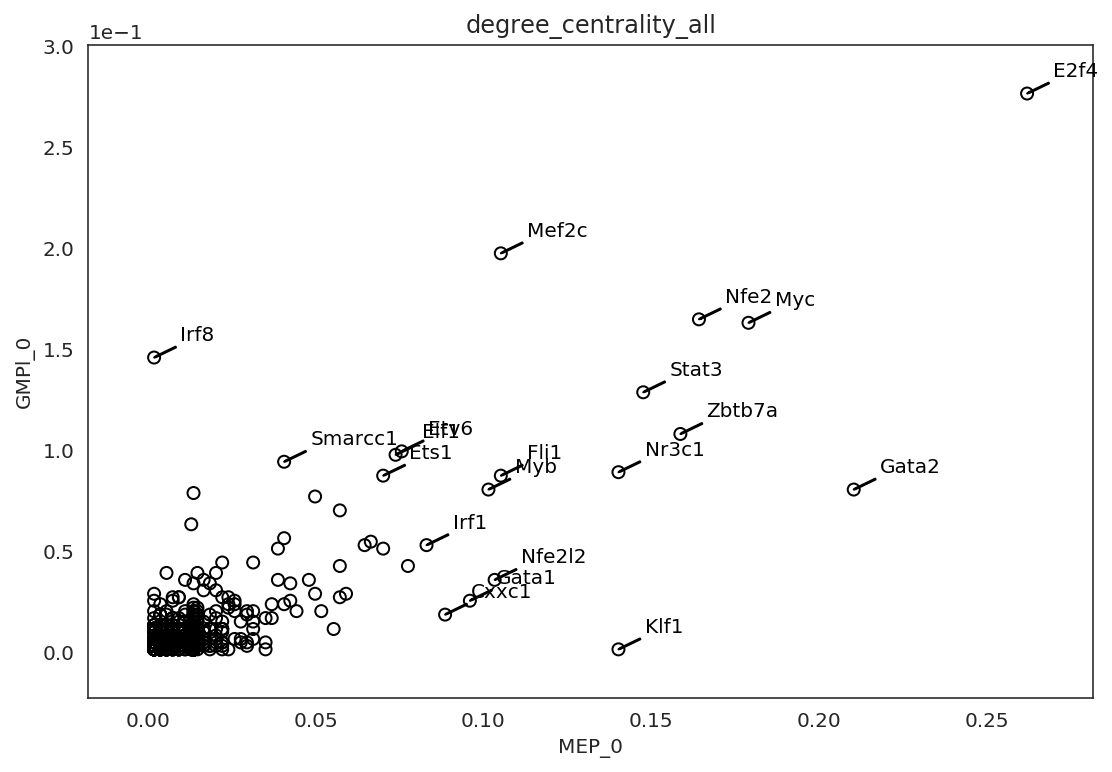

In [91]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="MEP_0", cluster2="GMPl_0", 
                               percentile=98, save=f"{save_folder}/score_comparison")

## 6.3. Network score dynamics
We can analyze how gene function/importance change over the differentiation by the following analysis.

Gata2 is known to play an important role in the early progenitor population; MEP, GMP. 
The following results can recapitulate the Gata2 feature.


Gata2


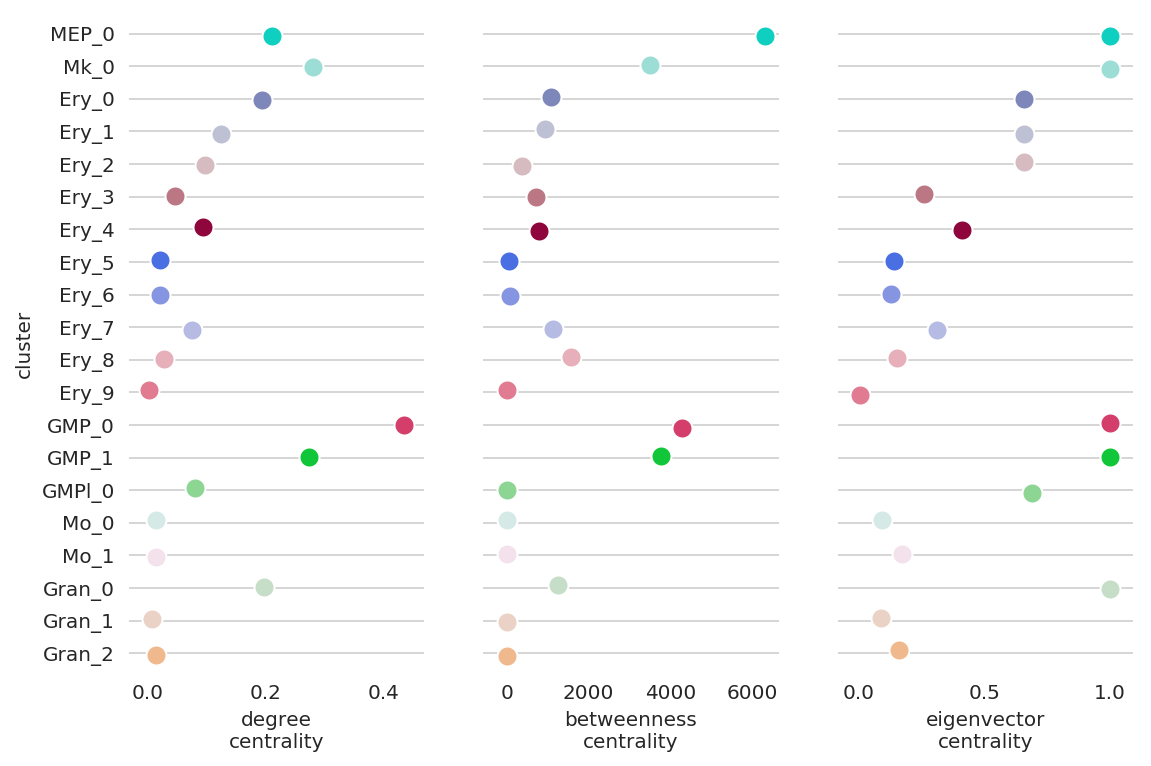

In [92]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="Gata2", save=f"{save_folder}/network_score_per_gene/")

## 6.4. Gene cartography analysis

Gene cartography is a method for gene network analysis.
The method classifies the gene into several groups using the network module structure and gene connections.
It provides us an insight about the regulatory mechanism per each gene. 
Please read the paper for the details of gene cartography (https://www.nature.com/articles/nature03288) 

The calculations of gene cartography will be performed for the GRN in each cluster.
Thus we can know how gene role change by comparing the cartography in each cluster.

Ery_0


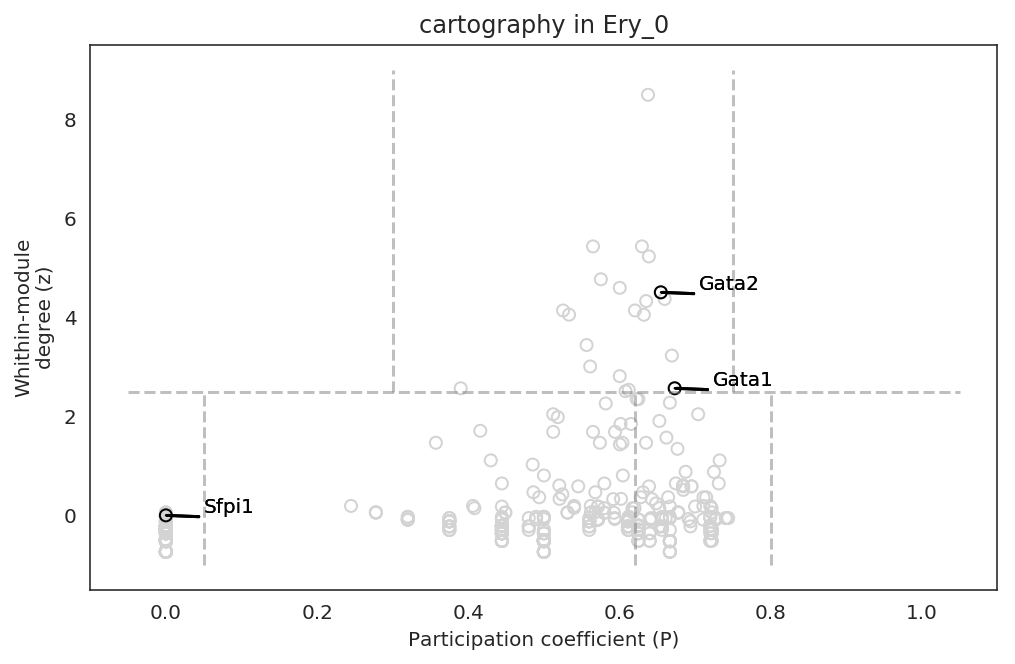

Ery_1


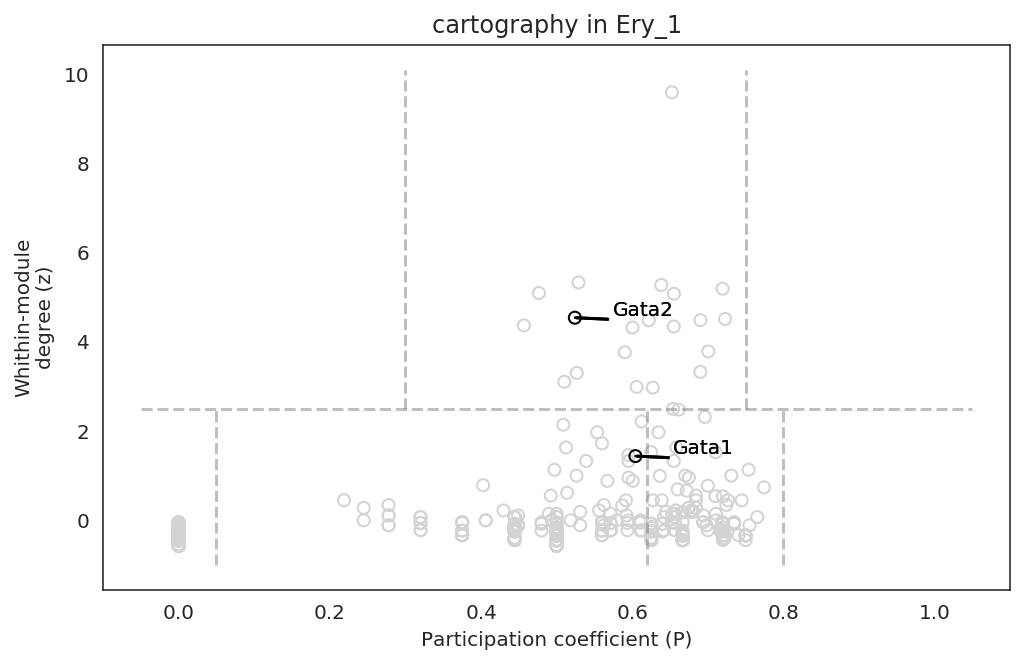

Ery_2


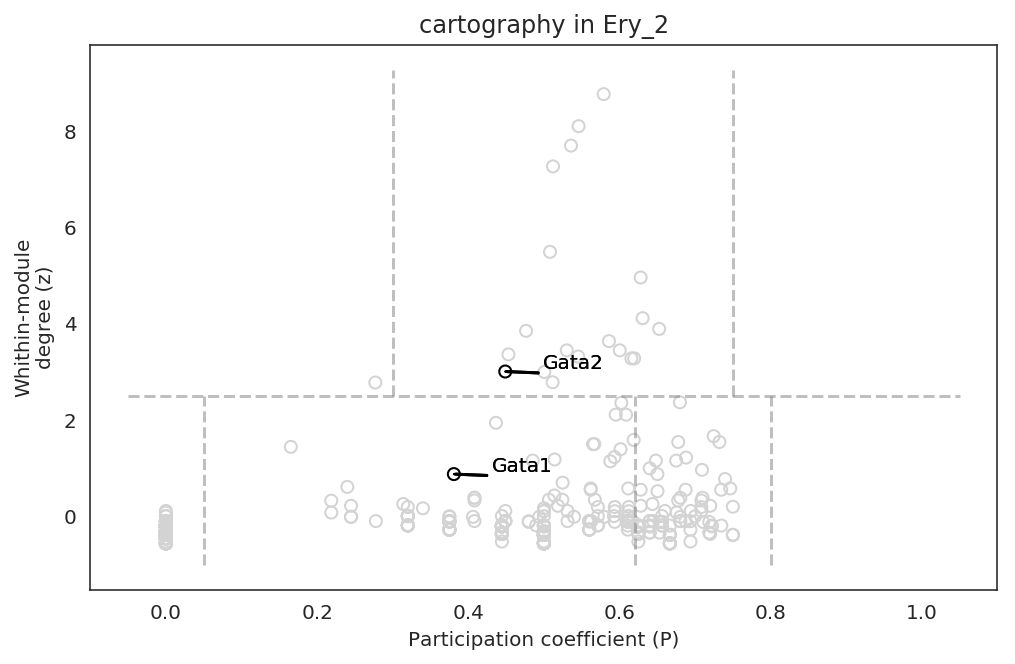

Ery_3


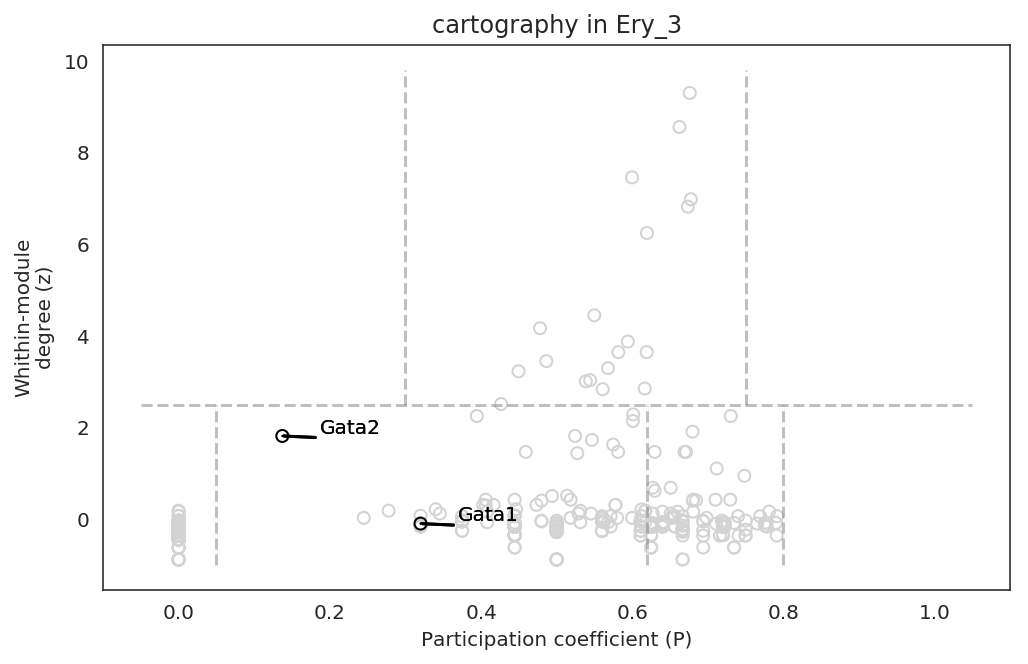

Ery_4


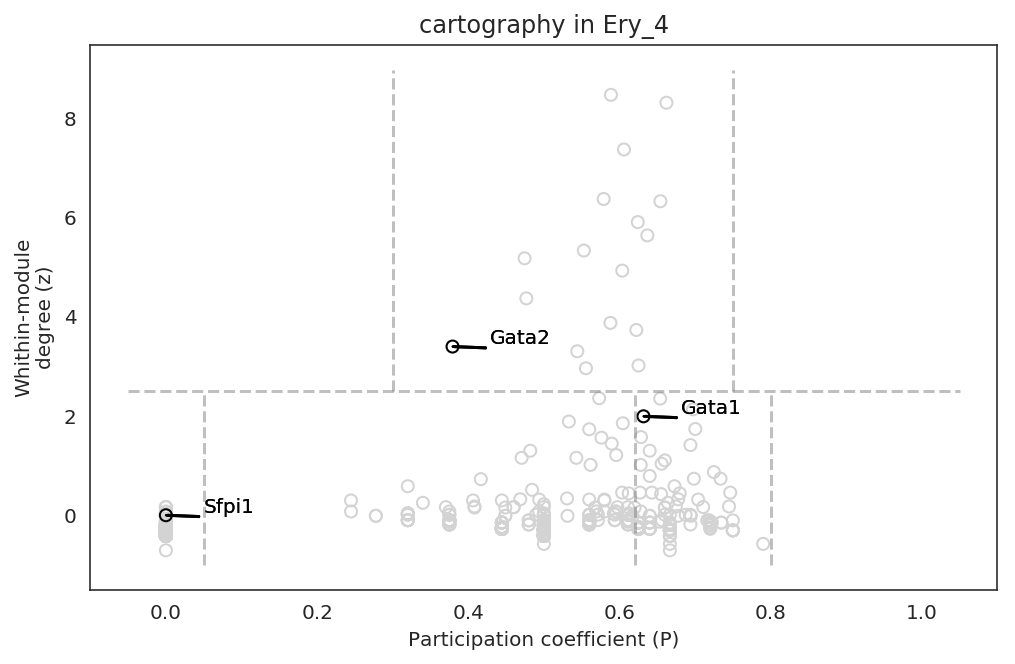

Ery_5


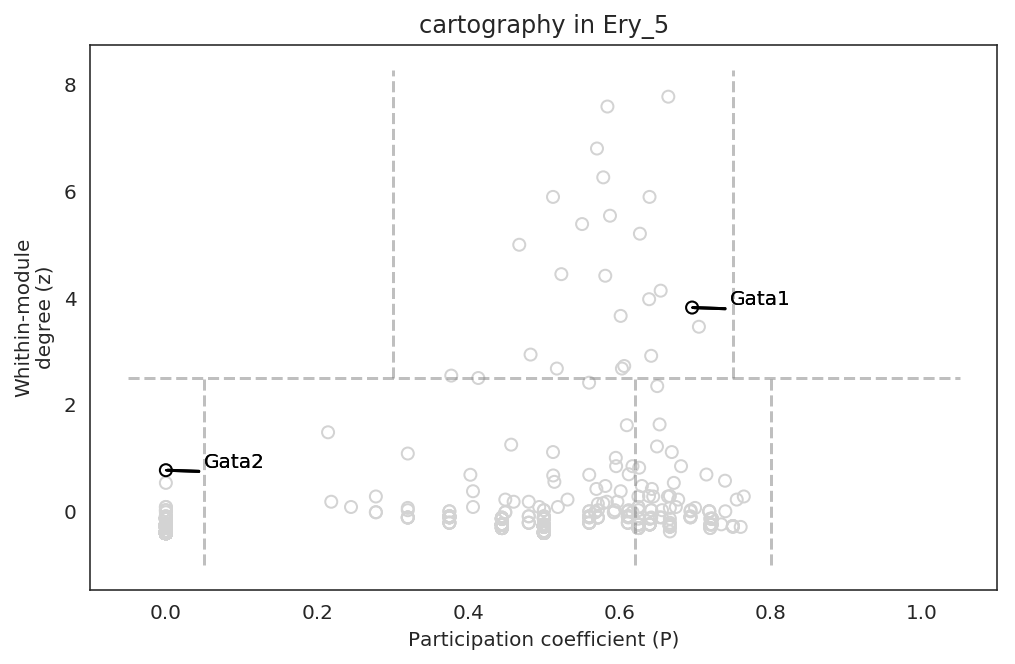

Ery_6


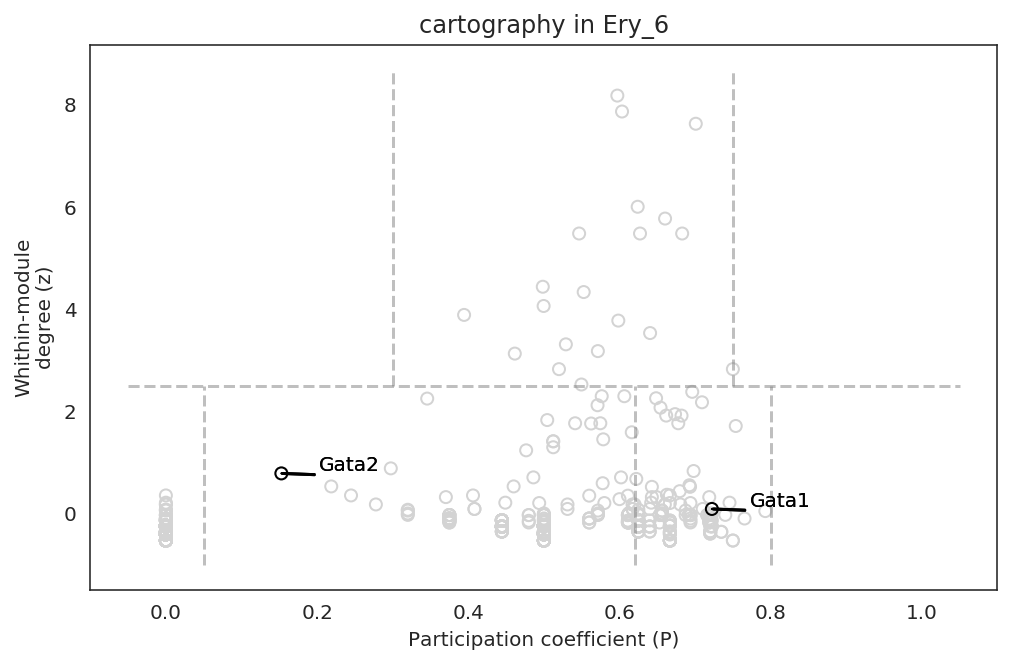

Ery_7


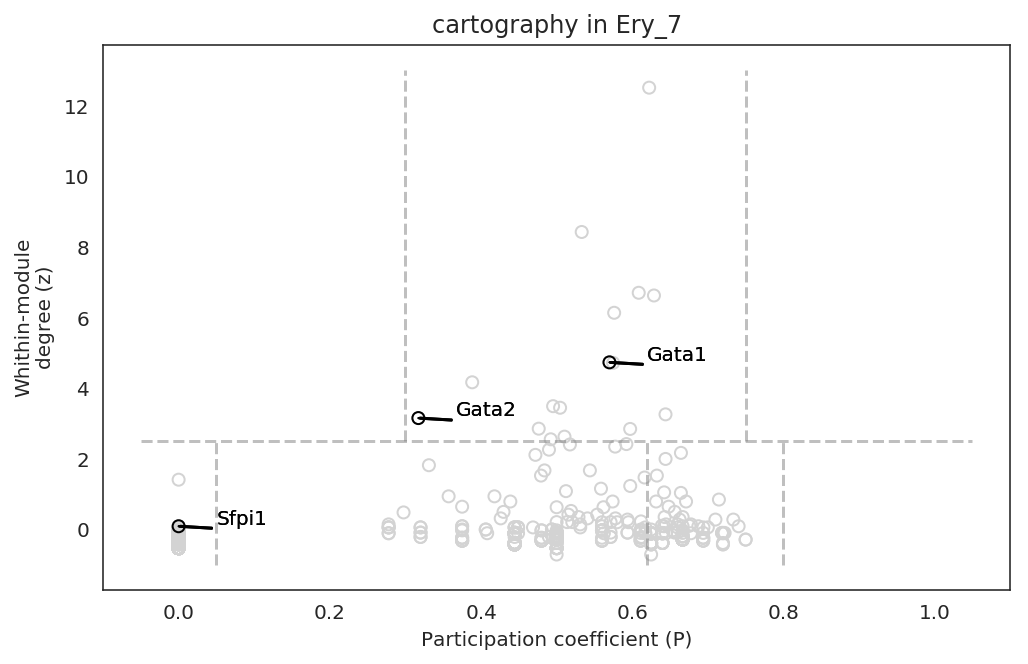

Ery_8


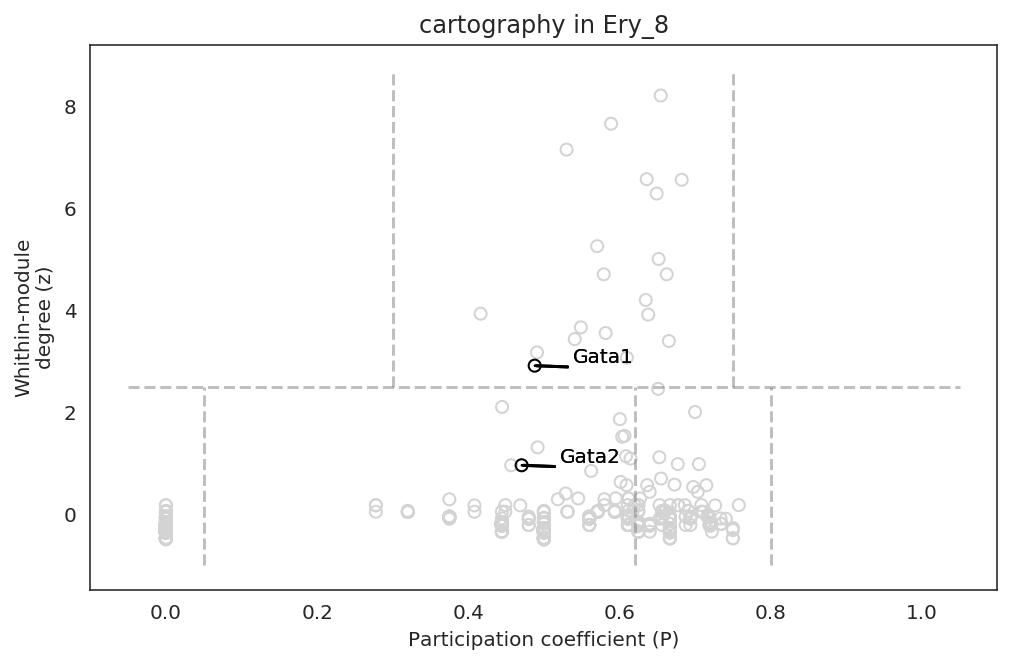

Ery_9


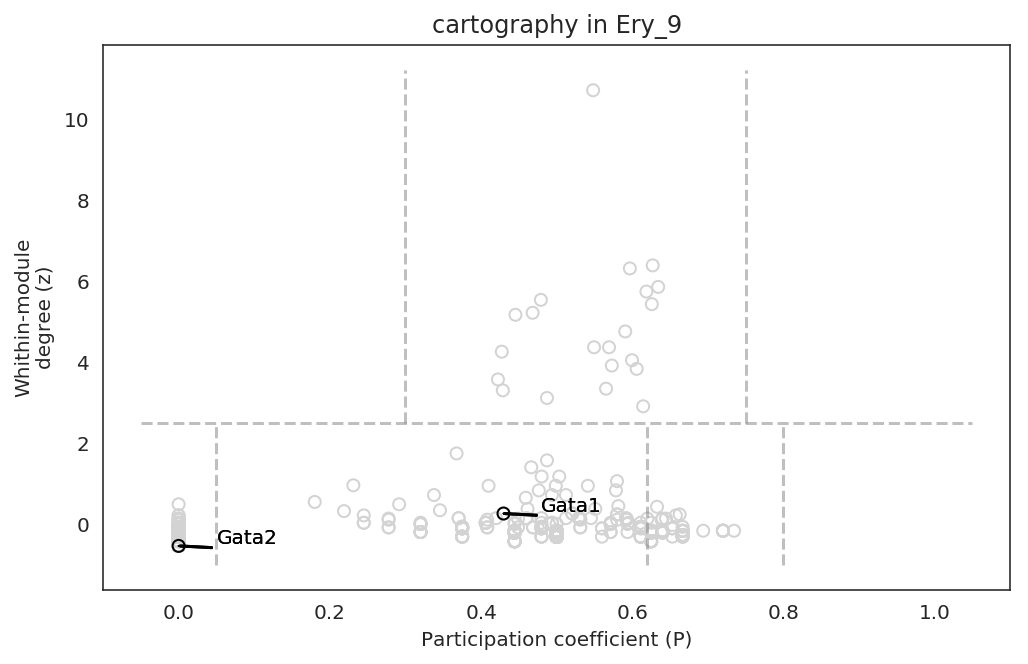

GMP_0


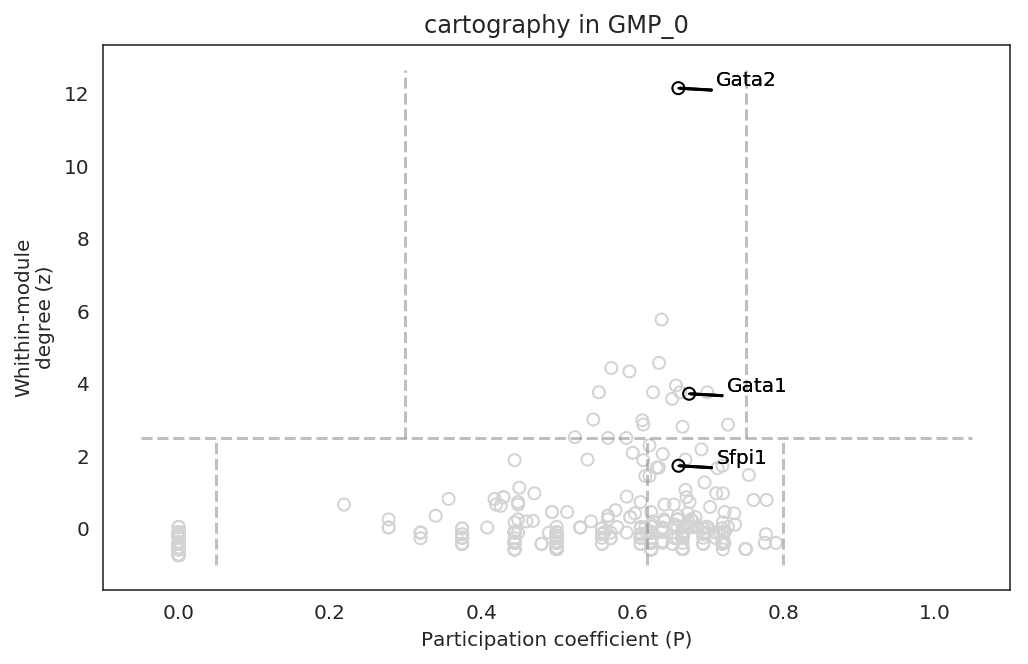

GMP_1


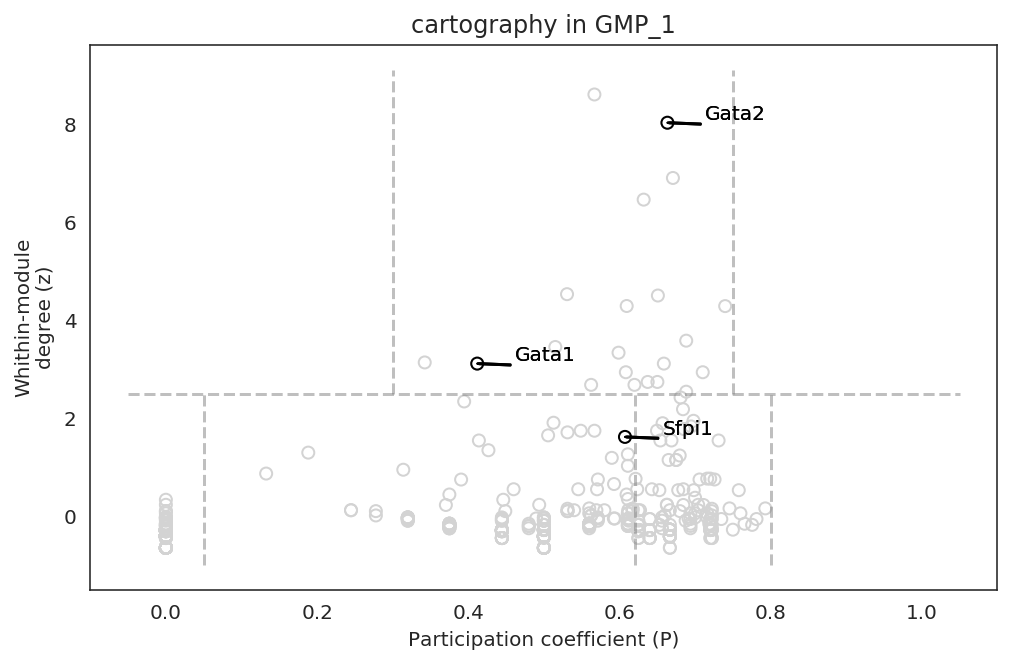

GMPl_0


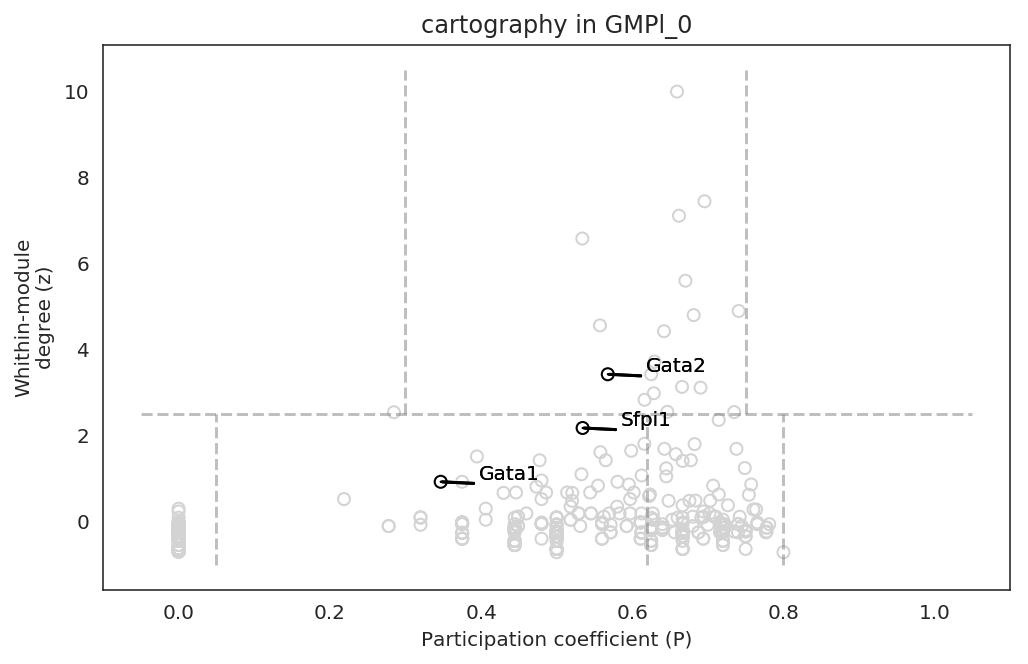

Gran_0


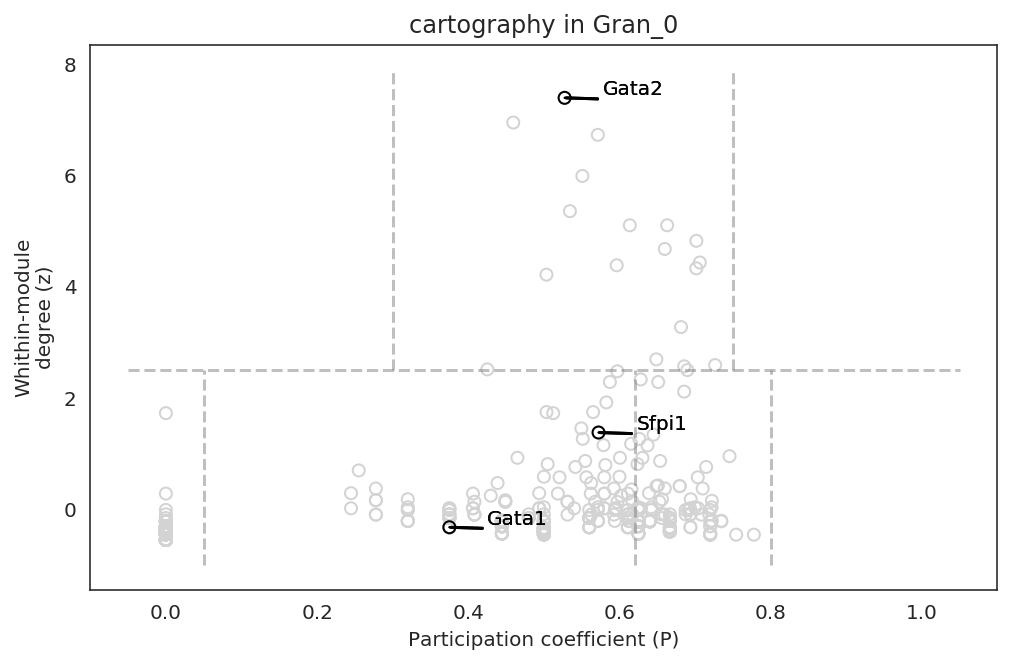

Gran_1


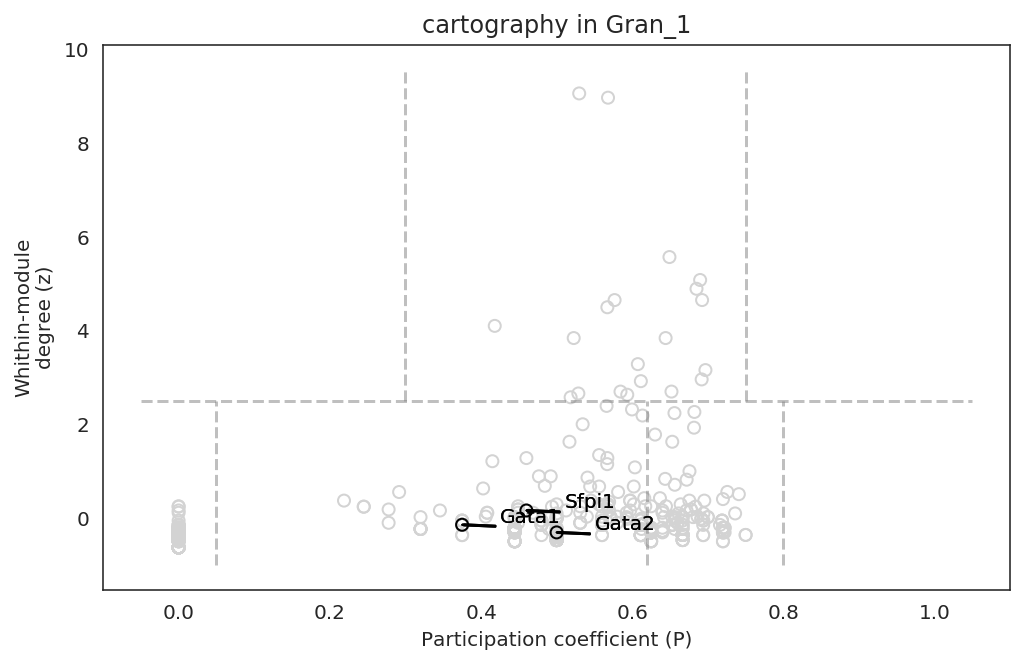

Gran_2


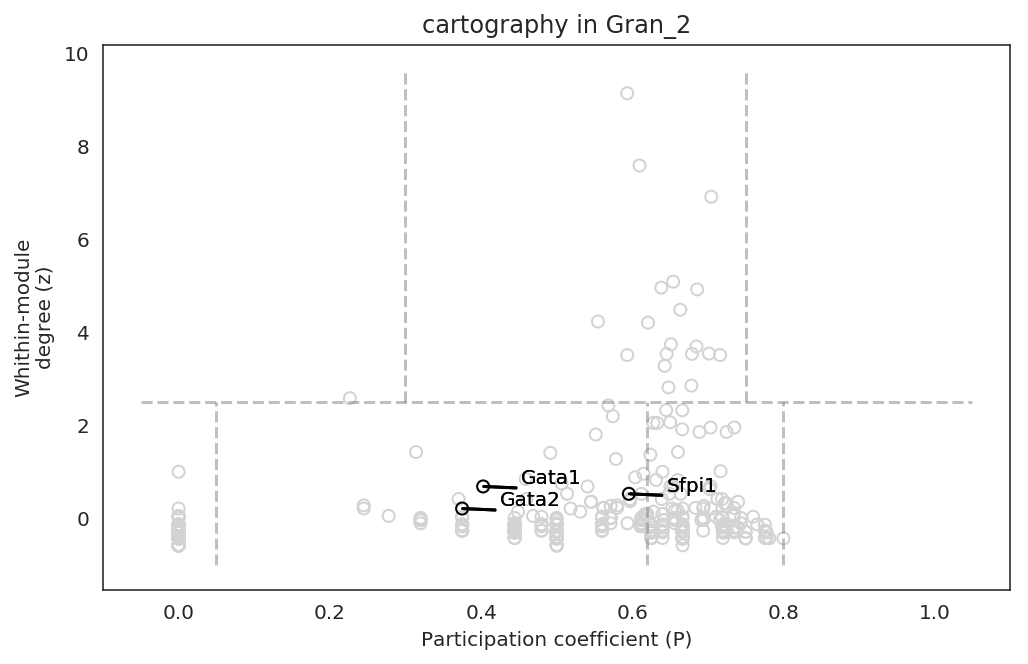

MEP_0


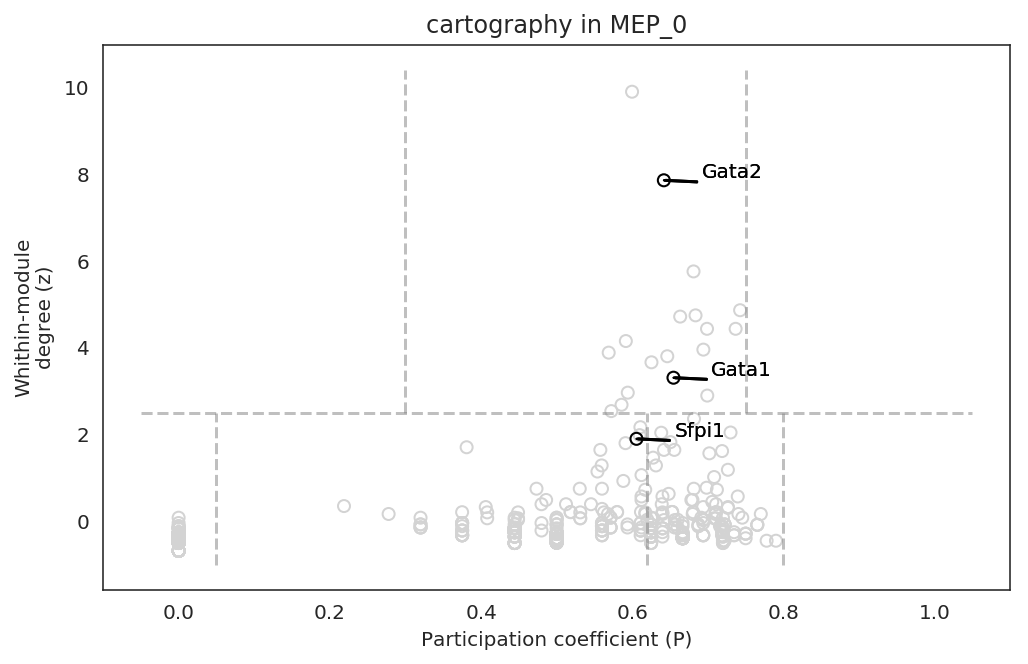

Mk_0


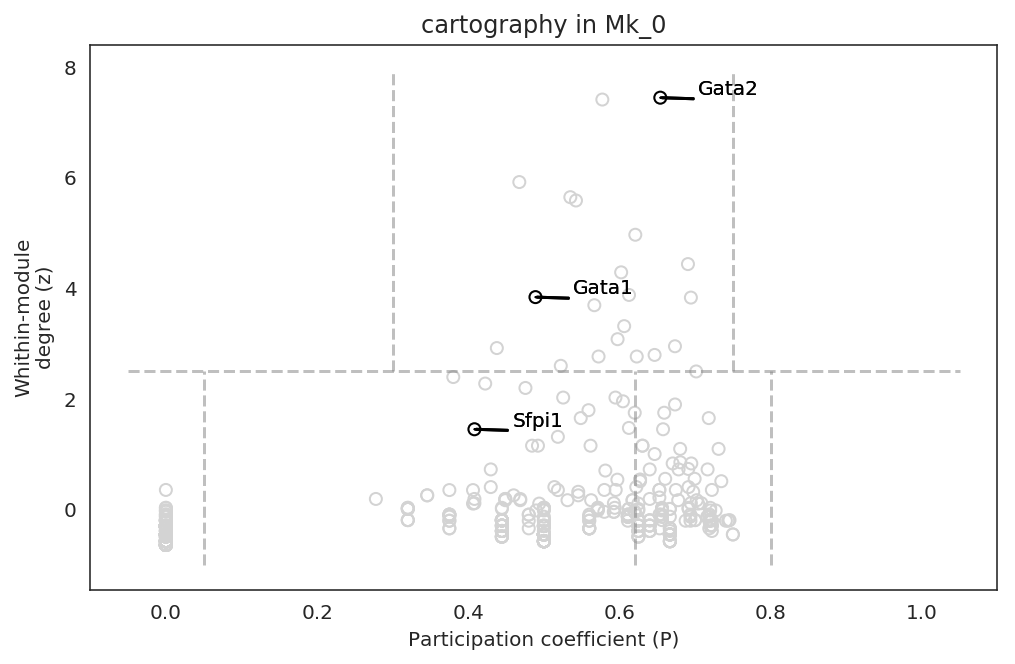

Mo_0


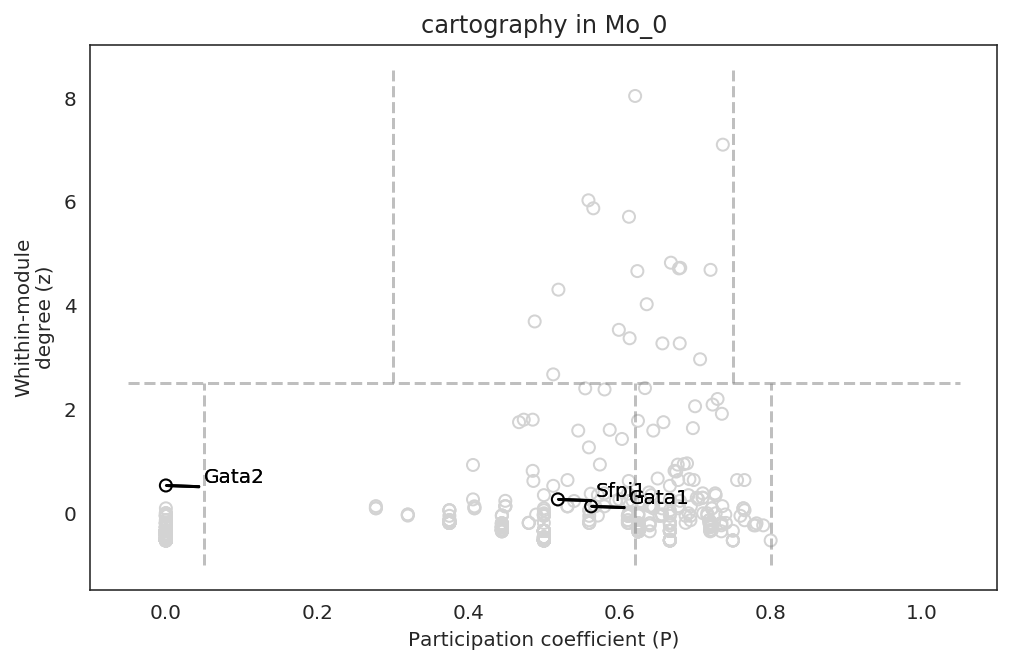

Mo_1


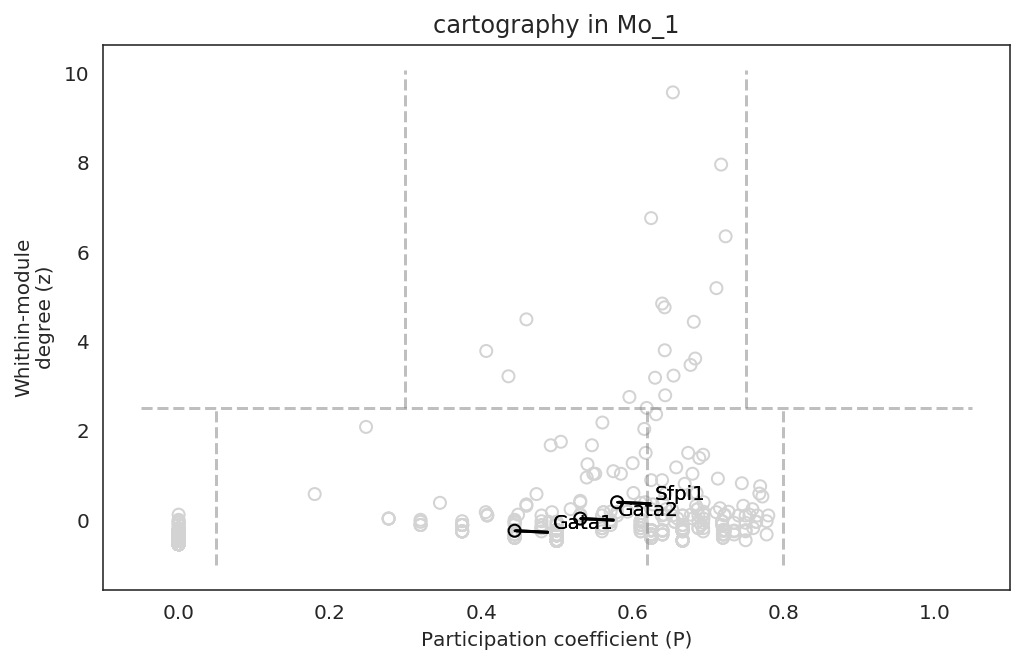

In [93]:
# plot cartography as a scatter plot
links.plot_cartography_scatter_per_cluster(scatter=True,
                                           kde=False,
                                           gois=["Gata1", "Gata2", "Sfpi1"],
                                           auto_gene_annot=False,
                                           percentile=99.5,
                                           args_dot={"n_levels": 105},
                                           args_line={"c":"gray"}, save=f"{save_folder}/cartography")

Gata2


/home/k/anaconda3/envs/test/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


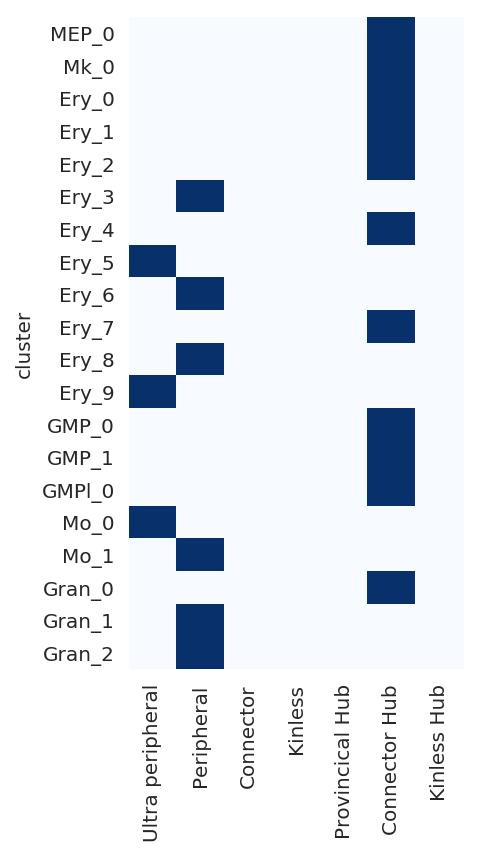

In [94]:
# plot the results of cartography analysis
plt.figure(figsize=[3,6])
links.plot_cartography_term(goi="Gata2", save=f"{save_folder}/cartography")

# 7. Network analysis; Network score distribution

Next, we visualize the distribution of network score to get insight into the global trend about the structure of GRNs.

## 7.1. Distribution of network degree

degree_centrality_all


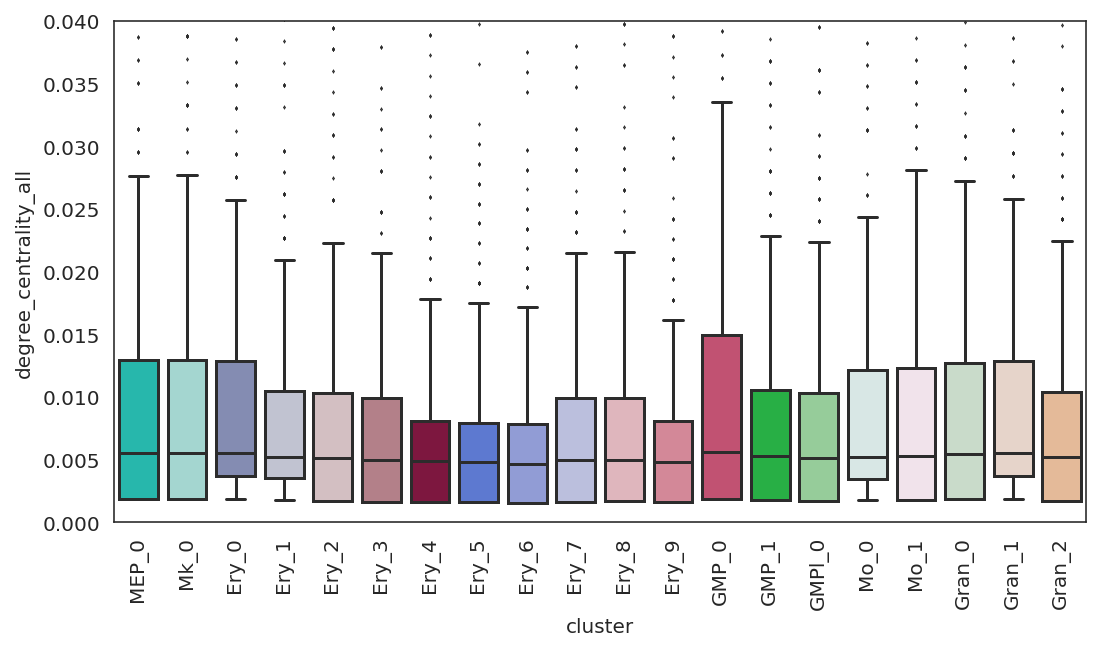

In [95]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot", save=f"{save_folder}")



eigenvector_centrality


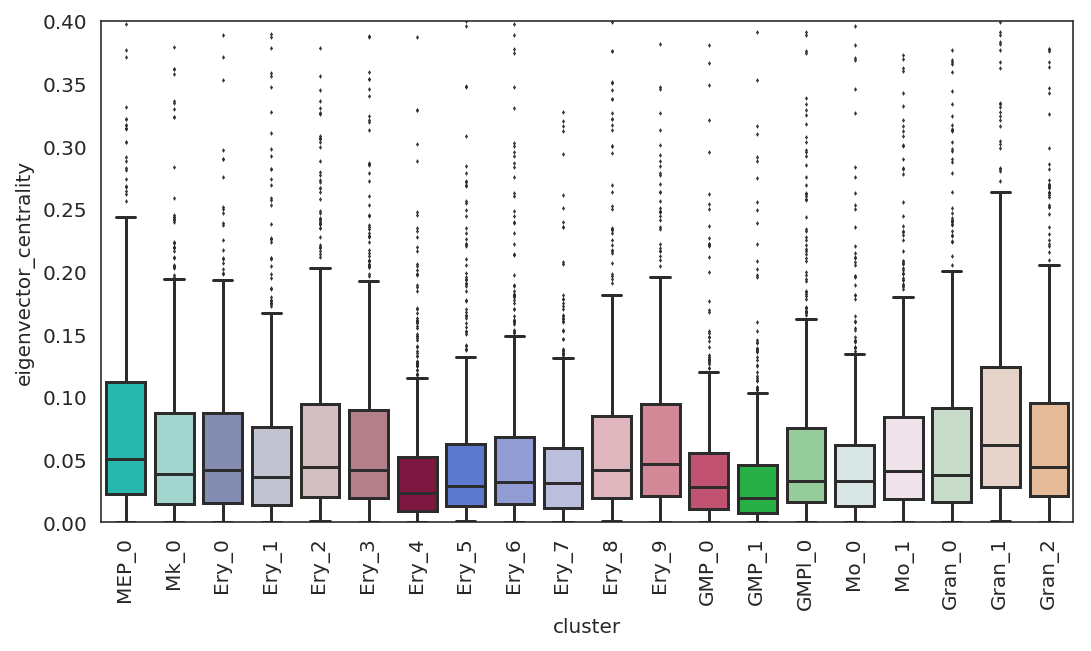

In [96]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.40])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot", save=f"{save_folder}")




## 7.2. Distribution of netowrk entolopy

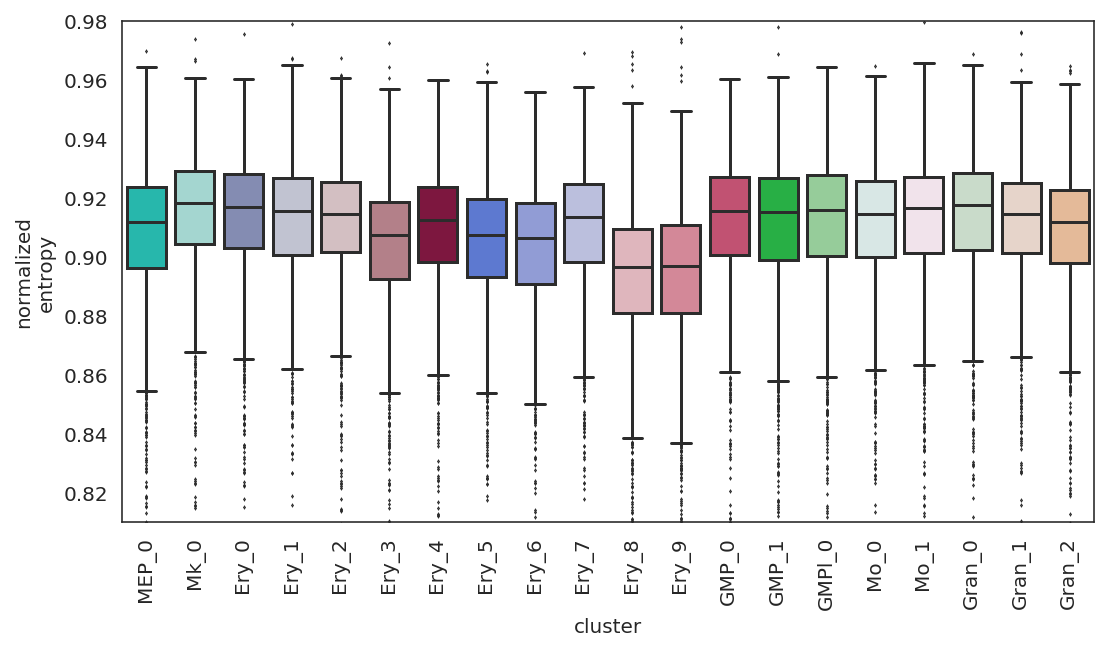

In [97]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")



In the example below, we did several network analysis and showed that several TFs have high network scores.
The TFs, for example "Gata2", "Gata1", "Klf1", "E2f1", are known to play an important role in MEP.
Using the network score, we may pick up cluster-specific key TFs.

In this step, however, we cannot know the specific function or relationship between cell fate. 
We just pick up several candidate genes for Key TFs here, and in the next analysis, we investigate their function and relationship between cell fate by the simulation with GRNs.